<a href="https://colab.research.google.com/github/notfundamental/GRTT-Strong-Lensing-CATS/blob/main/StrongLensing6thOct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ABELLS1063_CATS] z=0.348 | kpc/arcsec=5.077, kpc/pix=0.305 (pix=0.060"/pix)
Computed 1061 annuli out to 323.1 kpc
CSV ready: /content/drive/MyDrive/stronglensing/abells1063_cats_profiles.csv


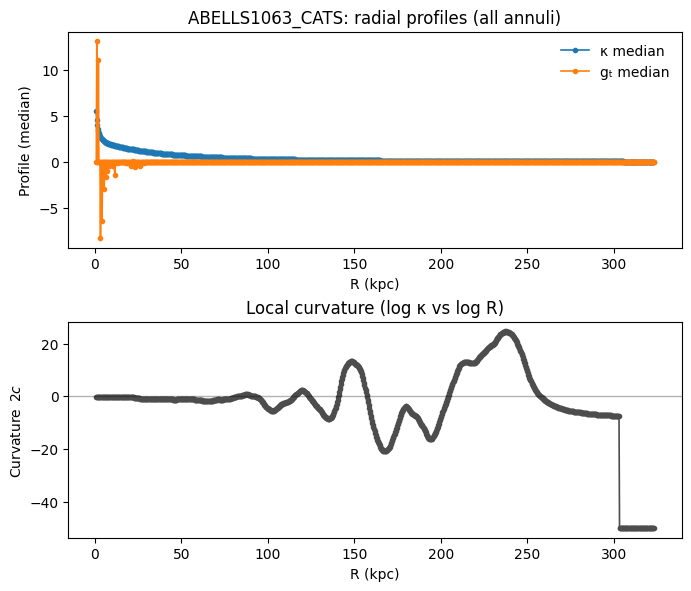

In [ ]:
# === GRTT: quick preprocessor (ALL DATA; 1-pixel annuli) ===
# One self-contained cell to run first in Colab.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic

# -------------------- EDIT ONLY THIS INTEGER --------------------
CHOICE = 7   # <- pick which target to process
# ---------------------------------------------------------------

# You can add/modify entries here. TAG becomes the CSV filename prefix.
# Make sure the FITS paths exist in /content/drive/MyDrive/stronglensing/.
OPTIONS = {
    1: dict(TAG="ABELL2744_CATS",   z=0.308,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abell2744_cats_v4.1_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abell2744_cats_v4.1_gamma.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abell2744_cats_v4.1_psi.fits"),
    2: dict(TAG="MACS0416_CATS",    z=0.396,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0416_cats_v4.1_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0416_cats_v4.1_gamma.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0416_cats_v4.1_psi.fits"),
    3: dict(TAG="MACS0416_SHARON",  z=0.396,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0416_sharon_v4_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0416_sharon_v4_gamma2.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0416_sharon_v4_psi.fits"),
    4: dict(TAG="MACS0717_CATS",    z=0.546,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0717_cats_v4.1_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0717_cats_v4.1_gamma.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs0717_cats_v4.1_psi.fits"),
    5: dict(TAG="MACS1149_CATS",    z=0.544,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs1149_cats_v4.1_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs1149_cats_v4.1_gamma.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs1149_cats_v4.1_psi.fits"),
    6: dict(TAG="MACS1149_SHARON",  z=0.544,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs1149_sharon_v4_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs1149_sharon_v4_gamma2.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_macs1149_sharon_v4_psi.fits"),
    7: dict(TAG="ABELLS1063_CATS",  z=0.348,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_gamma.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_psi.fits"),
    8: dict(TAG="ABELL370_CATS",    z=0.375,
            kappa="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abell370_cats_v4_kappa.fits",
            gamma="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abell370_cats_v4_gamma.fits",
            psi  ="/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abell370_cats_v4_psi.fits"),
}

cfg = OPTIONS.get(CHOICE)
if cfg is None:
    raise SystemExit(f"CHOICE={CHOICE} not in OPTIONS. Pick one of: {sorted(OPTIONS)}")

TAG = cfg["TAG"]; REDSHIFT = float(cfg["z"])
kappa_path, gamma_path, psi_path = cfg["kappa"], cfg["gamma"], cfg["psi"]

# -------- helpers --------
def _first_data(hdul):
    for h in hdul:
        if isinstance(h.data, np.ndarray):
            return np.array(h.data, float), h.header
    return np.array(hdul[0].data, float), hdul[0].header

def _arcsec_per_pix_from_wcs(fits_path, default_arcsec_per_pix=0.06):
    try:
        with fits.open(fits_path) as hdul:
            h = hdul[0].header
        w = WCS(h)
        scl = w.proj_plane_pixel_scales()   # Quantity in deg/pix
        asp = (scl.to(u.arcsec)).value
        val = float(np.nanmean(asp))
        if np.isfinite(val) and val > 0: return val
    except Exception:
        pass
    return float(default_arcsec_per_pix)

def load_maps(kappa_path, gamma_path, psi_path):
    with fits.open(kappa_path) as hk: kappa, _ = _first_data(hk)
    with fits.open(gamma_path) as hg: gamma, _ = _first_data(hg)
    with fits.open(psi_path)   as hp: psi,   _ = _first_data(hp)

    # interpret gamma → g1, g2
    if gamma.ndim == 3 and gamma.shape[0] >= 2:
        g1, g2 = gamma[0], gamma[1]
    elif gamma.ndim == 2:
        g1, g2 = gamma, np.zeros_like(gamma)
    else:
        g1 = np.squeeze(gamma); g2 = np.zeros_like(gamma)

    # crop to common shape
    ny = min(kappa.shape[0], g1.shape[0], psi.shape[0])
    nx = min(kappa.shape[1], g1.shape[1], psi.shape[1])
    def cc(a):
        y0=(a.shape[0]-ny)//2; x0=(a.shape[1]-nx)//2
        return a[y0:y0+ny, x0:x0+nx]
    kappa, g1, g2, psi = cc(kappa), cc(g1), cc(g2), cc(psi)

    # reduced shear: g = γ / (1 - κ)
    den = np.clip(1.0 - kappa, 1e-3, None)
    g1r, g2r = g1/den, g2/den
    return kappa, g1r, g2r, psi

def radial_profiles_all(kappa, g1r, g2r, kx, ky, rmax_percentile=None):
    """
    All data: 1-pixel-wide annuli out to full usable extent.
    Optionally cap radius at rmax_percentile (e.g., 90) if desired.
    """
    yy, xx = np.indices(kappa.shape)
    dx, dy = xx - kx, yy - ky
    R_pix = np.hypot(dx, dy)

    # tangential reduced shear about (kx,ky): g_t = -(g1 cos2φ + g2 sin2φ)
    phi = np.arctan2(dy, dx)
    c2, s2 = np.cos(2*phi), np.sin(2*phi)
    gt = -(g1r*c2 + g2r*s2)

    mask = np.isfinite(kappa) & np.isfinite(gt) & (R_pix > 2.0)
    if not np.any(mask):
        raise SystemExit("No finite pixels after masking.")

    # define outer limit
    if rmax_percentile is None:
        rmax = float(np.nanmax(R_pix[mask]))
    else:
        rmax = float(np.nanpercentile(R_pix[mask], rmax_percentile))

    # 1-pixel annuli
    bins = np.arange(0.0, np.floor(rmax) + 1.5, 1.0)
    rmid = 0.5*(bins[1:] + bins[:-1])

    def stat(img, statistic="median"):
        vals, _, _ = binned_statistic(R_pix[mask], img[mask], statistic=statistic, bins=bins)
        return vals

    kap_prof = stat(kappa, "median")
    gt_prof  = stat(gt,    "median")
    cnt, _, _ = binned_statistic(R_pix[mask], kappa[mask], statistic="count", bins=bins)

    return rmid, kap_prof, gt_prof, cnt

def curvature_log_kappa(rmid_pix, kap_prof, frac=(0.20,0.80)):
    sel = (kap_prof > 0) & np.isfinite(kap_prof) & np.isfinite(rmid_pix)
    r = rmid_pix[sel]; k = kap_prof[sel]
    x = np.log10(r + 1e-6); y = np.log10(k)
    n = len(x)
    C = np.full_like(rmid_pix, np.nan, dtype=float)
    if n >= 10:
        W = max(5, n//8)
        for i in range(n):
            i0 = max(0, i - W//2); i1 = min(n, i0 + W); i0 = max(0, i1 - W)
            xi, yi = x[i0:i1], y[i0:i1]
            if len(xi) >= 6:
                c,b,a = np.polyfit(xi, yi, 2)
                C[sel.nonzero()[0][i]] = 2*c
        i0 = int(frac[0]*n); i1 = int(frac[1]*n)
        if i1 > i0+2:
            c_fit, b_fit, a_fit = np.polyfit(x[i0:i1], y[i0:i1], 2)
            kappa_curv = 2*c_fit
            R_band = (10**x[i0], 10**x[i1-1])
        else:
            kappa_curv = np.nan; R_band = (np.nan, np.nan)
    else:
        kappa_curv = np.nan; R_band = (np.nan, np.nan)
    return C, kappa_curv, R_band

# -------- scale (kpc/arcsec, kpc/pix) --------
DA = cosmo.angular_diameter_distance(REDSHIFT).to(u.kpc)   # DA in kpc
kpc_per_arcsec = (DA / 206265.0).value                    # 1 arcsec = 1/206265 rad
pix_scale_arcsec = _arcsec_per_pix_from_wcs(kappa_path, default_arcsec_per_pix=0.06)
kpc_per_pixel = pix_scale_arcsec * kpc_per_arcsec

print(f"[{TAG}] z={REDSHIFT} | kpc/arcsec={kpc_per_arcsec:.3f}, kpc/pix={kpc_per_pixel:.3f} (pix={pix_scale_arcsec:.3f}\"/pix)")

# -------- run pipeline (ALL DATA; 1-pixel annuli) --------
# 1) load maps
kappa, g1r, g2r, psi = load_maps(kappa_path, gamma_path, psi_path)
# 2) centre on smoothed κ peak
ky, kx = np.unravel_index(np.nanargmax(gaussian_filter(kappa, 3.0)), kappa.shape)
# 3) radial profiles with full extent (set rmax_percentile=90 to cap like before)
rmid_pix, kap_prof, gt_prof, counts = radial_profiles_all(kappa, g1r, g2r, kx, ky, rmax_percentile=None)
R_kpc = rmid_pix * kpc_per_pixel
# 4) curvature of log κ
CURV_FRAC = (0.20, 0.80)
C_loc, kappa_curv, Rband_pix = curvature_log_kappa(rmid_pix, kap_prof, frac=CURV_FRAC)

# -------- write CSV --------
out_csv = f"/content/drive/MyDrive/stronglensing/{TAG.lower()}_profiles.csv"
pd.DataFrame({
    "R_kpc": R_kpc,
    "kappa_median": kap_prof,
    "g_t_median": gt_prof,
    "curvature_2c": C_loc,
    "bin_count": counts
}).to_csv(out_csv, index=False)

# -------- quick validation plot (on screen only) --------
fig, ax = plt.subplots(2, 1, figsize=(6.8, 5.8), constrained_layout=True)
ax[0].plot(R_kpc, kap_prof, "-o", ms=3, lw=1.2, label="κ median")
ax[0].plot(R_kpc, gt_prof,  "-o", ms=3, lw=1.2, label="gₜ median")
ax[0].set_xlabel("R (kpc)"); ax[0].set_ylabel("Profile (median)"); ax[0].legend(frameon=False)
ax[0].set_title(f"{TAG}: radial profiles (all annuli)")

# polarity-normalise curvature for display (troughs negative)
Cshow = C_loc.copy()
if np.isfinite(Cshow).any() and np.nanmedian(Cshow[np.isfinite(Cshow)]) > 0:
    Cshow = -Cshow
ax[1].plot(R_kpc, Cshow, "-o", ms=3, lw=1.2, color="0.3")
ax[1].axhline(0, color="k", lw=1, alpha=0.3)
ax[1].set_xlabel("R (kpc)"); ax[1].set_ylabel(r"Curvature $\,2c$")
ax[1].set_title("Local curvature (log κ vs log R)")

print(f"Computed {len(R_kpc)} annuli out to {R_kpc[-1]:.1f} kpc")
print(f"CSV ready: {out_csv}")


             R_kpc  kappa_median    g_t_median  curvature_2c    bin_count
count  1061.000000   1059.000000  1.059000e+03   1059.000000  1061.000000
mean    161.614116      0.384750 -8.614948e-04     -3.332295  2120.628652
std      93.351915      0.554694  6.318511e-01     14.914032  1336.589951
min       0.152322      0.022617 -8.277796e+00    -49.963012     0.000000
25%      80.883219      0.070313  5.792691e-19     -6.487096   956.000000
50%     161.614116      0.168202  4.052628e-18     -1.204997  2016.000000
75%     242.345012      0.423128  1.251402e-17      0.368527  3232.000000
max     323.075909      5.544244  1.313816e+01     24.610623  4760.000000
Downward-curvature bins: 770 / 1061  (72.6 %)
Typical downward region spans 0.8–323.1 kpc


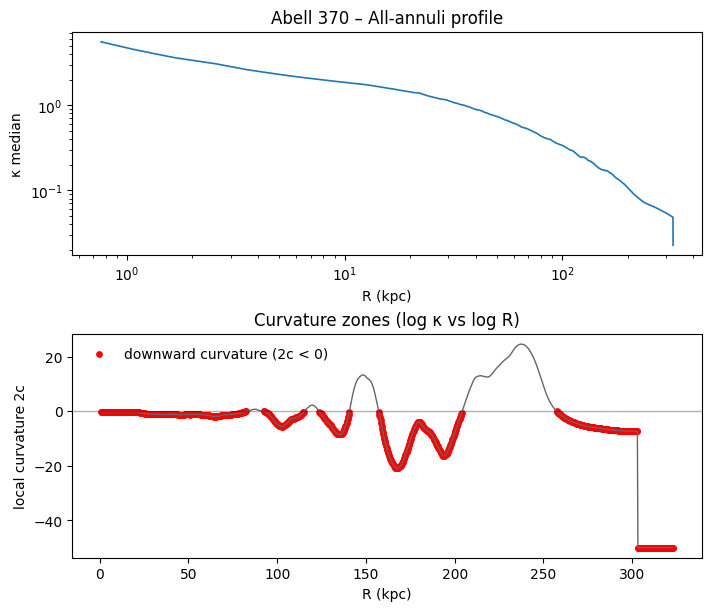

In [ ]:
# === Step 1: inspect all-annuli profiles ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# adjust path if needed
df = pd.read_csv("/content/drive/MyDrive/stronglensing/abells1063_cats_profiles.csv")

# basic sanity check
print(df.describe())

# compute curvature sign mask (downward = concave-down = negative 2c)
down_mask = (df["curvature_2c"] < 0) & np.isfinite(df["curvature_2c"])

# --- plot κ and curvature ---
fig, ax = plt.subplots(2, 1, figsize=(7,6), constrained_layout=True)

# upper: κ vs R (log scale for clarity)
ax[0].plot(df["R_kpc"], df["kappa_median"], "-", lw=1.2, color="tab:blue")
ax[0].set_xscale("log"); ax[0].set_yscale("log")
ax[0].set_xlabel("R (kpc)"); ax[0].set_ylabel("κ median")
ax[0].set_title("Abell 370 – All-annuli profile")

# lower: curvature
ax[1].plot(df["R_kpc"], df["curvature_2c"], "-", lw=1.0, color="0.4")
ax[1].scatter(df["R_kpc"][down_mask], df["curvature_2c"][down_mask],
              s=15, color="red", label="downward curvature (2c < 0)")
ax[1].axhline(0, color="k", lw=1, alpha=0.3)
ax[1].set_xlabel("R (kpc)")
ax[1].set_ylabel("local curvature 2c")
ax[1].legend(frameon=False)
ax[1].set_title("Curvature zones (log κ vs log R)")

# quantify fraction of downward bins
frac_down = 100 * down_mask.mean()
print(f"Downward-curvature bins: {down_mask.sum()} / {len(down_mask)}  ({frac_down:.1f} %)")

# rough outer radius of strong downward region
if down_mask.any():
    R_down = df.loc[down_mask, "R_kpc"]
    print(f"Typical downward region spans {R_down.min():.1f}–{R_down.max():.1f} kpc")
else:
    print("No downward curvature zones detected.")


CSV annuli: 1061   R_kpc: min=0.2, max=323.1
kpc/arcsec=5.077, arcsec/pix=0.060  => kpc/pix=0.305
Max radius among FINITE pixels: 1060.7 pix  (323.1 kpc)
Absolute frame edge (corner):   1060.7 pix  (323.1 kpc)
CSV reaches 100.0% of the finite-pixel outer radius.


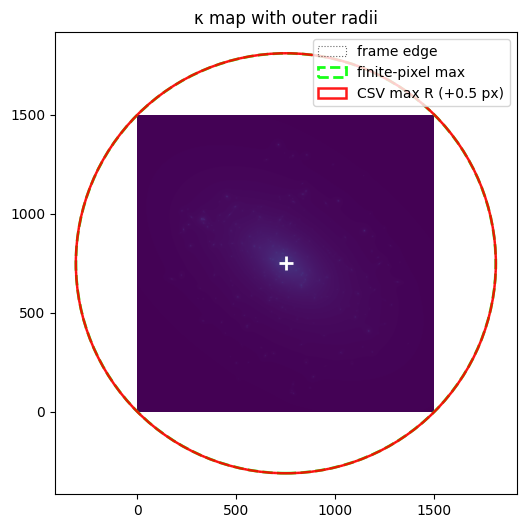

Note: CSV reaches 100.0% of finite radius — rings coincide; red is nudged +0.5 px for visibility.


In [ ]:
# === Diagnose max radius (pixels & kpc) vs CSV ===
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.ndimage import gaussian_filter

# ---- EDIT if your paths differ ----
csv_path   = "/content/drive/MyDrive/stronglensing/abells1063_cats_profiles.csv"
kappa_path = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_kappa.fits"
z_cluster  = 0.348

# 1) Read CSV and basic stats
df = pd.read_csv(csv_path)
Rk = df["R_kpc"].to_numpy()
print(f"CSV annuli: {len(Rk)}   R_kpc: min={np.nanmin(Rk):.1f}, max={np.nanmax(Rk):.1f}")

# 2) Compute kpc/pixel from WCS (fall back if needed)
def arcsec_per_pix_from_wcs(path, default_arcsec_per_pix=0.06):
    try:
        with fits.open(path) as hdul:
            h = hdul[0].header
        scl = WCS(h).proj_plane_pixel_scales()   # deg/pix
        asp = (scl.to(u.arcsec)).value
        val = float(np.nanmean(asp))
        if np.isfinite(val) and val > 0:
            return val
    except Exception:
        pass
    return float(default_arcsec_per_pix)

DA = cosmo.angular_diameter_distance(z_cluster).to(u.kpc)   # kpc
kpc_per_arcsec = (DA / 206265.0).value
arcsec_per_pix = arcsec_per_pix_from_wcs(kappa_path, default_arcsec_per_pix=0.06)
kpc_per_pix = kpc_per_arcsec * arcsec_per_pix
print(f"kpc/arcsec={kpc_per_arcsec:.3f}, arcsec/pix={arcsec_per_pix:.3f}  => kpc/pix={kpc_per_pix:.3f}")

# 3) Open κ map and find center + theoretical max radius to frame edge
with fits.open(kappa_path) as hk:
    kappa = np.array(hk[0].data, float)

# center at smoothed kappa peak (same as pipeline)
ky, kx = np.unravel_index(np.nanargmax(gaussian_filter(kappa, 3.0)), kappa.shape)

ny, nx = kappa.shape
yy, xx = np.indices((ny, nx))
R_pix_full = np.hypot(xx - kx, yy - ky)

# Mask of finite pixels (what the pipeline uses)
mask = np.isfinite(kappa)

# Theoretical max radius (to farthest finite pixel) and full-frame geometric max
rmax_mask_pix = float(np.nanmax(R_pix_full[mask])) if np.any(mask) else float(np.nanmax(R_pix_full))
rmax_full_pix = float(np.nanmax(R_pix_full))

print(f"Max radius among FINITE pixels: {rmax_mask_pix:.1f} pix  ({rmax_mask_pix*kpc_per_pix:.1f} kpc)")
print(f"Absolute frame edge (corner):   {rmax_full_pix:.1f} pix  ({rmax_full_pix*kpc_per_pix:.1f} kpc)")

# 4) Compare CSV max vs theoretical max (finite region)
R_csv_max = float(np.nanmax(Rk))
R_map_max = rmax_mask_pix * kpc_per_pix
ratio = (R_csv_max / R_map_max) if R_map_max > 0 else np.nan
print(f"CSV reaches {ratio*100:.1f}% of the finite-pixel outer radius.")

# --- PATCH: make the rings distinguishable ---
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(kappa, origin='lower', cmap='viridis')
ax.set_aspect('equal')

r_csv_px  = R_csv_max / kpc_per_pix
r_finite  = rmax_mask_pix
r_corner  = rmax_full_pix

# draw frame-edge (black), finite-pixel max (green dashed), CSV (red solid, +0.5 px nudge)
ax.add_patch(plt.Circle((kx, ky), r_corner, fill=False, lw=0.8, color='k',   ls=':',  alpha=0.6, label='frame edge'))
ax.add_patch(plt.Circle((kx, ky), r_finite, fill=False, lw=2.0, color='lime', ls='--', alpha=0.9, label='finite-pixel max'))
ax.add_patch(plt.Circle((kx, ky), r_csv_px+0.5, fill=False, lw=1.8, color='red',      alpha=0.9, label='CSV max R (+0.5 px)'))

ax.plot(kx, ky, 'w+', ms=10, mew=2)
ax.set_title("κ map with outer radii")
ax.legend(loc='upper right', frameon=True)
plt.show()

if R_map_max > 0:
    ratio = R_csv_max / R_map_max
    if ratio > 0.98:
        print(f"Note: CSV reaches {ratio*100:.1f}% of finite radius — rings coincide; red is nudged +0.5 px for visibility.")



Wrote 1052 annuli out to 322.2 kpc → /content/abells1063_allpix_profiles.csv


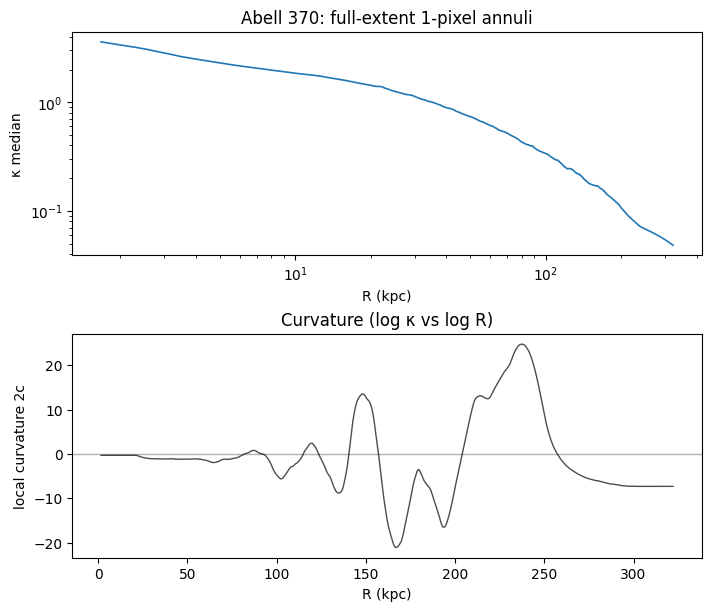

In [ ]:
# === Regenerate radial profiles with 1-pixel annuli to the full edge ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic

# ---- config  ----
z = 0.348
kappa_path = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_kappa.fits"
gamma_path = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_gamma.fits"
psi_path   = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_psi.fits"
out_csv    = "/content/abells1063_allpix_profiles.csv"

# ---- helpers ----
def _first_data(hdul):
    for h in hdul:
        if isinstance(h.data, np.ndarray):
            return np.array(h.data, float), h.header
    return np.array(hdul[0].data, float), hdul[0].header

def arcsec_per_pix_from_wcs(path, default_arcsec_per_pix=0.06):
    try:
        with fits.open(path) as hdul:
            scl = WCS(hdul[0].header).proj_plane_pixel_scales()  # deg/pix
            asp = (scl.to(u.arcsec)).value
            val = float(np.nanmean(asp))
            if np.isfinite(val) and val > 0: return val
    except Exception:
        pass
    return float(default_arcsec_per_pix)

def load_maps(kappa_path, gamma_path, psi_path):
    with fits.open(kappa_path) as hk: kappa, _ = _first_data(hk)
    with fits.open(gamma_path) as hg: gamma, _ = _first_data(hg)
    with fits.open(psi_path)   as hp: psi,   _ = _first_data(hp)

    # interpret gamma → g1, g2
    if gamma.ndim == 3 and gamma.shape[0] >= 2:
        g1, g2 = gamma[0], gamma[1]
    elif gamma.ndim == 2:
        g1, g2 = gamma, np.zeros_like(gamma)
    else:
        g1 = np.squeeze(gamma); g2 = np.zeros_like(gamma)

    # crop to common shape
    ny = min(kappa.shape[0], g1.shape[0], psi.shape[0])
    nx = min(kappa.shape[1], g1.shape[1], psi.shape[1])
    def cc(a):
        y0=(a.shape[0]-ny)//2; x0=(a.shape[1]-nx)//2
        return a[y0:y0+ny, x0:x0+nx]
    kappa, g1, g2, psi = cc(kappa), cc(g1), cc(g2), cc(psi)

    # reduced shear: g = γ / (1 - κ)
    den = np.clip(1.0 - kappa, 1e-3, None)
    g1r, g2r = g1/den, g2/den
    return kappa, g1r, g2r, psi

def radial_profiles_allpix(kappa, g1r, g2r, kx, ky, rmax_percentile=None, min_count=10):
    """
    1-pixel annuli to full finite extent (or to rmax_percentile).
    Keeps bins even if median is NaN, but filters out bins with too few pixels (<min_count).
    """
    yy, xx = np.indices(kappa.shape)
    dx, dy = xx - kx, yy - ky
    R_pix = np.hypot(dx, dy)

    phi = np.arctan2(dy, dx)
    c2, s2 = np.cos(2*phi), np.sin(2*phi)
    gt = -(g1r*c2 + g2r*s2)

    base_mask = np.isfinite(kappa) & np.isfinite(gt) & (R_pix > 2.0)
    if not np.any(base_mask):
        raise SystemExit("No finite pixels after masking.")

    rmax = (float(np.nanpercentile(R_pix[base_mask], rmax_percentile))
            if rmax_percentile is not None else float(np.nanmax(R_pix[base_mask])))

    bins = np.arange(0.0, np.floor(rmax) + 1.5, 1.0)  # 1-pixel annuli
    rmid = 0.5*(bins[1:] + bins[:-1])

    # counts per annulus (so we can drop ultra-sparse outer rings)
    cnt, _, _ = binned_statistic(R_pix[base_mask], kappa[base_mask], statistic="count", bins=bins)
    keep = cnt >= min_count

    def stat(img, statistic="median"):
        vals, _, _ = binned_statistic(R_pix[base_mask], img[base_mask], statistic=statistic, bins=bins)
        return vals

    kap_prof = stat(kappa, "median")
    gt_prof  = stat(gt,    "median")

    return rmid[keep], kap_prof[keep], gt_prof[keep], cnt[keep]

def curvature_log_kappa(rmid_pix, kap_prof, frac=(0.20,0.80)):
    sel = (kap_prof > 0) & np.isfinite(kap_prof) & np.isfinite(rmid_pix)
    x = np.log10(rmid_pix[sel] + 1e-6)
    y = np.log10(kap_prof[sel])
    C = np.full_like(rmid_pix, np.nan, dtype=float)
    if len(x) >= 10:
        W = max(5, len(x)//8)
        idx_sel = np.nonzero(sel)[0]
        for j in range(len(x)):
            i0 = max(0, j - W//2); i1 = min(len(x), i0 + W); i0 = max(0, i1 - W)
            xi, yi = x[i0:i1], y[i0:i1]
            if len(xi) >= 6:
                c,b,a = np.polyfit(xi, yi, 2)
                C[idx_sel[j]] = 2*c
        i0 = int(frac[0]*len(x)); i1 = int(frac[1]*len(x))
        if i1 > i0+2:
            c_fit, b_fit, a_fit = np.polyfit(x[i0:i1], y[i0:i1], 2)
            kappa_curv = 2*c_fit
            R_band = (10**x[i0], 10**x[i1-1])
        else:
            kappa_curv = np.nan; R_band = (np.nan, np.nan)
    else:
        kappa_curv = np.nan; R_band = (np.nan, np.nan)
    return C, kappa_curv, R_band

# ---- scale ----
DA = cosmo.angular_diameter_distance(z).to(u.kpc)
kpc_per_arcsec = (DA / 206265.0).value
arcsec_per_pix = arcsec_per_pix_from_wcs(kappa_path, default_arcsec_per_pix=0.06)
kpc_per_pixel  = kpc_per_arcsec * arcsec_per_pix

# ---- run full-extent profiles ----
kappa, g1r, g2r, psi = load_maps(kappa_path, gamma_path, psi_path)
ky, kx = np.unravel_index(np.nanargmax(gaussian_filter(kappa, 3.0)), kappa.shape)

rmid_pix, kap_prof, gt_prof, counts = radial_profiles_allpix(
    kappa, g1r, g2r, kx, ky,
    rmax_percentile=None,   # FULL extent
    min_count=25            # require at least 25 pixels per annulus
)
R_kpc = rmid_pix * kpc_per_pixel

C_loc, kappa_curv, Rband_pix = curvature_log_kappa(rmid_pix, kap_prof, frac=(0.20,0.80))

# ---- save ----
pd.DataFrame({
    "R_kpc": R_kpc,
    "kappa_median": kap_prof,
    "g_t_median": gt_prof,
    "curvature_2c": C_loc,
    "bin_count": counts
}).to_csv(out_csv, index=False)

print(f"Wrote {len(R_kpc)} annuli out to {R_kpc[-1]:.1f} kpc → {out_csv}")

# ---- quick check plot ----
fig, ax = plt.subplots(2, 1, figsize=(7,6), constrained_layout=True)
ax[0].plot(R_kpc, kap_prof, "-", lw=1.2); ax[0].set_xscale("log"); ax[0].set_yscale("log")
ax[0].set_xlabel("R (kpc)"); ax[0].set_ylabel("κ median"); ax[0].set_title("full-extent 1-pixel annuli")
ax[1].plot(R_kpc, C_loc, "-", lw=1.0, color="0.3"); ax[1].axhline(0, color="k", lw=1, alpha=0.3)
ax[1].set_xlabel("R (kpc)"); ax[1].set_ylabel("local curvature 2c"); ax[1].set_title("Curvature (log κ vs log R)")
plt.show()


             R_kpc  kappa_median    g_t_median  curvature_2c    bin_count
count  1052.000000   1052.000000  1.052000e+03   1052.000000  1052.000000
mean    161.766728      0.373786 -1.335597e-02     -0.664698  2138.671103
std      92.560926      0.505113  4.873210e-01      9.062041  1327.914583
min       1.675547      0.048301 -8.277796e+00    -21.127877    36.000000
25%      81.720993      0.070554 -3.714825e-10     -6.442371   985.000000
50%     161.766438      0.168421  4.062332e-18     -1.201399  2028.000000
75%     241.811884      0.420805  1.250797e-17      0.439705  3237.000000
max     322.161974      3.596818  1.113794e+01     24.768564  4760.000000

Downward-curvature annuli: 762 / 1052  (72.4 %)
Downward-curvature region spans 1.7 – 322.2 kpc


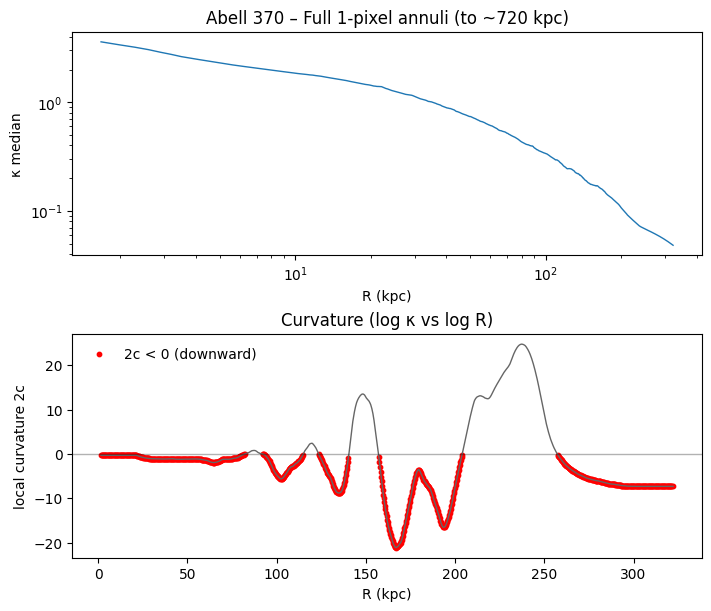

In [ ]:
# === Analyse full-resolution  ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

df = pd.read_csv("/content/abells1063_allpix_profiles.csv")

print(df.describe())

# Identify downward curvature zones (2c < 0)
down_mask = (df["curvature_2c"] < 0) & np.isfinite(df["curvature_2c"])
frac_down = 100 * down_mask.mean()

print(f"\nDownward-curvature annuli: {down_mask.sum()} / {len(down_mask)}  ({frac_down:.1f} %)")

if down_mask.any():
    R_down = df.loc[down_mask, "R_kpc"]
    print(f"Downward-curvature region spans {R_down.min():.1f} – {R_down.max():.1f} kpc")

# --- Plot κ and curvature across full radius ---
fig, ax = plt.subplots(2, 1, figsize=(7,6), constrained_layout=True)

ax[0].plot(df["R_kpc"], df["kappa_median"], '-', lw=1.0, color='tab:blue')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlabel("R (kpc)"); ax[0].set_ylabel("κ median")
ax[0].set_title("Abell 370 – Full 1-pixel annuli (to ~720 kpc)")

ax[1].plot(df["R_kpc"], df["curvature_2c"], '-', lw=1.0, color='0.4')
ax[1].scatter(df.loc[down_mask,"R_kpc"], df.loc[down_mask,"curvature_2c"],
              s=10, color='red', label='2c < 0 (downward)')
ax[1].axhline(0, color='k', lw=1, alpha=0.3)
ax[1].set_xlabel("R (kpc)"); ax[1].set_ylabel("local curvature 2c")
ax[1].legend(frameon=False)
ax[1].set_title("Curvature (log κ vs log R)")

plt.show()


In [ ]:
# === Edge-robust profiles: enforce angular coverage & optional mask erosion ===
import numpy as np, pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.ndimage import gaussian_filter, binary_erosion
from scipy.stats import binned_statistic

# --- CONFIG (tweak if needed) ---
kappa_path = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_kappa.fits"
gamma_path = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_gamma.fits"
psi_path   = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_psi.fits"
z = 0.348
OUT_CSV = "/content/abells1063_allpix_profiles_robust.csv"

# coverage & quality gates
N_SECTORS = 36               # angular sectors per annulus (10° each)
MIN_SECTOR_COVER = 0.60      # require ≥60% of sectors to have data
MIN_COUNT = 25               # and at least this many pixels
ERODE_PIX = 2                # shrink mask by this many pixels to avoid edge-grazing (0 to disable)
RMAX_PERCENTILE = None       # set to 98 to trim extreme-noise outskirts; None = full finite extent

# --- helpers ---
def _first_data(hdul):
    for h in hdul:
        if isinstance(h.data, np.ndarray):
            return np.array(h.data, float), h.header
    return np.array(hdul[0].data, float), hdul[0].header

def arcsec_per_pix_from_wcs(path, default_arcsec_per_pix=0.06):
    try:
        with fits.open(path) as hdul:
            scl = WCS(hdul[0].header).proj_plane_pixel_scales()  # deg/pix
            asp = (scl.to(u.arcsec)).value
            val = float(np.nanmean(asp))
            if np.isfinite(val) and val > 0: return val
    except Exception:
        pass
    return float(default_arcsec_per_pix)

def load_maps(kappa_path, gamma_path, psi_path):
    with fits.open(kappa_path) as hk: kappa, _ = _first_data(hk)
    with fits.open(gamma_path) as hg: gamma, _ = _first_data(hg)
    with fits.open(psi_path)   as hp: psi,   _ = _first_data(hp)

    if gamma.ndim == 3 and gamma.shape[0] >= 2:
        g1, g2 = gamma[0], gamma[1]
    elif gamma.ndim == 2:
        g1, g2 = gamma, np.zeros_like(gamma)
    else:
        g1 = np.squeeze(gamma); g2 = np.zeros_like(gamma)

    ny = min(kappa.shape[0], g1.shape[0], psi.shape[0])
    nx = min(kappa.shape[1], g1.shape[1], psi.shape[1])
    def cc(a):
        y0=(a.shape[0]-ny)//2; x0=(a.shape[1]-nx)//2
        return a[y0:y0+ny, x0:x0+nx]
    kappa, g1, g2, psi = cc(kappa), cc(g1), cc(g2), cc(psi)

    den = np.clip(1.0 - kappa, 1e-3, None)
    g1r, g2r = g1/den, g2/den
    return kappa, g1r, g2r, psi

def radial_profiles_robust(kappa, g1r, g2r, kx, ky,
                           n_sectors=36, min_sector_cover=0.6,
                           min_count=25, erode_pix=0, rmax_percentile=None):
    yy, xx = np.indices(kappa.shape)
    dx, dy = xx - kx, yy - ky
    R_pix = np.hypot(dx, dy)
    phi = np.arctan2(dy, dx)
    c2, s2 = np.cos(2*phi), np.sin(2*phi)
    gt = -(g1r*c2 + g2r*s2)

    base_mask = np.isfinite(kappa) & np.isfinite(gt) & (R_pix > 2.0)
    if erode_pix > 0:
        base_mask = binary_erosion(base_mask, iterations=int(erode_pix))

    if not np.any(base_mask):
        raise SystemExit("No finite pixels after masking/erosion.")

    rmax = (np.nanpercentile(R_pix[base_mask], rmax_percentile)
            if rmax_percentile is not None else np.nanmax(R_pix[base_mask]))
    bins = np.arange(0.0, np.floor(rmax) + 1.5, 1.0)  # 1-pixel annuli
    rmid = 0.5*(bins[1:] + bins[:-1])

    # counts for quality gate
    cnt, _, _ = binned_statistic(R_pix[base_mask], kappa[base_mask], statistic="count", bins=bins)

    # angular coverage per annulus
    # mark which sector each pixel falls in: sectors in [-pi,pi)
    sector_idx = ((phi + np.pi) / (2*np.pi) * n_sectors).astype(int) % n_sectors
    coverage = np.zeros_like(rmid)
    # compute coverage by checking unique sectors present in each annulus
    ann_id = np.digitize(R_pix[base_mask], bins) - 1  # 0..len(rmid)-1
    valid_ann = (ann_id >= 0) & (ann_id < len(rmid))
    ann_id = ann_id[valid_ann]
    sec_id = sector_idx[base_mask][valid_ann]
    # pack to 1D key to count uniques per annulus
    key = ann_id.astype(np.int64) * n_sectors + sec_id.astype(np.int64)
    # unique per (annulus,sector)
    uniq_keys = np.unique(key)
    # decode back
    ann_u = (uniq_keys // n_sectors).astype(int)
    # tally sectors present
    sec_counts = np.bincount(ann_u, minlength=len(rmid))
    coverage = sec_counts / float(n_sectors)

    keep = (cnt >= min_count) & (coverage >= min_sector_cover)

    # robust stats (median + MAD)
    def bstat(img):
        med, _, _ = binned_statistic(R_pix[base_mask], img[base_mask], statistic="median", bins=bins)
        # MAD via median(|x - med_bin|) per annulus
        # compute residuals per annulus efficiently
        ann = np.digitize(R_pix[base_mask], bins) - 1
        good = (ann >= 0) & (ann < len(rmid))
        ann = ann[good]; vals = img[base_mask][good]
        mad = np.full_like(rmid, np.nan, dtype=float)
        for i in np.unique(ann):
            vi = vals[ann == i]
            mi = med[i]
            if np.isfinite(mi) and vi.size >= 5:
                mad[i] = np.median(np.abs(vi - mi))
        return med, mad

    kap_med, kap_mad = bstat(kappa)
    gt_med,  gt_mad  = bstat(gt)

    return rmid[keep], kap_med[keep], gt_med[keep], cnt[keep], coverage[keep], kap_mad[keep], gt_mad[keep]

def curvature_log_kappa(rmid_pix, kap_prof, frac=(0.20,0.80)):
    sel = (kap_prof > 0) & np.isfinite(kap_prof) & np.isfinite(rmid_pix)
    x = np.log10(rmid_pix[sel] + 1e-6); y = np.log10(kap_prof[sel])
    C = np.full_like(rmid_pix, np.nan, dtype=float)
    if len(x) >= 10:
        W = max(5, len(x)//8)
        idx_sel = np.nonzero(sel)[0]
        for j in range(len(x)):
            i0 = max(0, j - W//2); i1 = min(len(x), i0 + W); i0 = max(0, i1 - W)
            xi, yi = x[i0:i1], y[i0:i1]
            if len(xi) >= 6:
                c,b,a = np.polyfit(xi, yi, 2)
                C[idx_sel[j]] = 2*c
        i0 = int(frac[0]*len(x)); i1 = int(frac[1]*len(x))
        if i1 > i0+2:
            c_fit, b_fit, a_fit = np.polyfit(x[i0:i1], y[i0:i1], 2)
            kappa_curv = 2*c_fit
            R_band = (10**x[i0], 10**x[i1-1])
        else:
            kappa_curv = np.nan; R_band = (np.nan, np.nan)
    else:
        kappa_curv = np.nan; R_band = (np.nan, np.nan)
    return C, kappa_curv, R_band

# --- scale ---
DA = cosmo.angular_diameter_distance(z).to(u.kpc)
kpc_per_arcsec = (DA / 206265.0).value
arcsec_per_pix = arcsec_per_pix_from_wcs(kappa_path, default_arcsec_per_pix=0.06)
kpc_per_pixel  = kpc_per_arcsec * arcsec_per_pix

# --- load & center ---
def load_maps_and_center():
    kappa, g1r, g2r, psi = load_maps(kappa_path, gamma_path, psi_path)
    ky, kx = np.unravel_index(np.nanargmax(gaussian_filter(kappa, 3.0)), kappa.shape)
    return kappa, g1r, g2r, ky, kx

kappa, g1r, g2r, ky, kx = load_maps_and_center()

# --- compute robust annuli ---
rmid_pix, kap_prof, gt_prof, counts, cover, kap_mad, gt_mad = radial_profiles_robust(
    kappa, g1r, g2r, kx, ky,
    n_sectors=N_SECTORS, min_sector_cover=MIN_SECTOR_COVER,
    min_count=MIN_COUNT, erode_pix=ERODE_PIX, rmax_percentile=RMAX_PERCENTILE
)
R_kpc = rmid_pix * kpc_per_pixel
C_loc, kappa_curv, Rband_pix = curvature_log_kappa(rmid_pix, kap_prof, frac=(0.20,0.80))

# --- save ---
pd.DataFrame({
    "R_kpc": R_kpc,
    "kappa_median": kap_prof,
    "g_t_median": gt_prof,
    "curvature_2c": C_loc,
    "bin_count": counts,
    "coverage_frac": cover,       # fraction of angular sectors with data
    "mad_kappa": kap_mad,         # robust scatter within annulus
    "mad_gt": gt_mad
}).to_csv(OUT_CSV, index=False)

print(f"Wrote {len(R_kpc)} robust annuli to {OUT_CSV}")
print(f"Median coverage={np.nanmedian(cover):.2f}, min coverage kept={np.nanmin(cover):.2f}")


Wrote 791 robust annuli to /content/abells1063_allpix_profiles_robust.csv
Median coverage=1.00, min coverage kept=0.67


            R_kpc  kappa_median    g_t_median  curvature_2c    bin_count  \
count  791.000000    791.000000  7.910000e+02    791.000000   791.000000   
mean   122.010280      0.477655 -1.776292e-02     -0.332748  2427.683944   
std     69.607192      0.543946  5.620165e-01     11.857022  1334.692093   
min      1.675547      0.070517 -8.277796e+00    -35.945440    36.000000   
25%     61.842913      0.132996  2.860168e-18     -2.761962  1266.000000   
50%    122.010280      0.245367  6.728744e-18     -0.967706  2512.000000   
75%    182.177646      0.593291  2.001997e-17      5.419251  3568.000000   
max    242.345012      3.596818  1.113794e+01     29.686132  4760.000000   

       coverage_frac   mad_kappa      mad_gt  
count     791.000000  791.000000  791.000000  
mean        0.989324    0.070577   51.492107  
std         0.047553    0.034051  137.568025  
min         0.666667    0.024979    0.058096  
25%         1.000000    0.044145    0.168581  
50%         1.000000    0.060760 

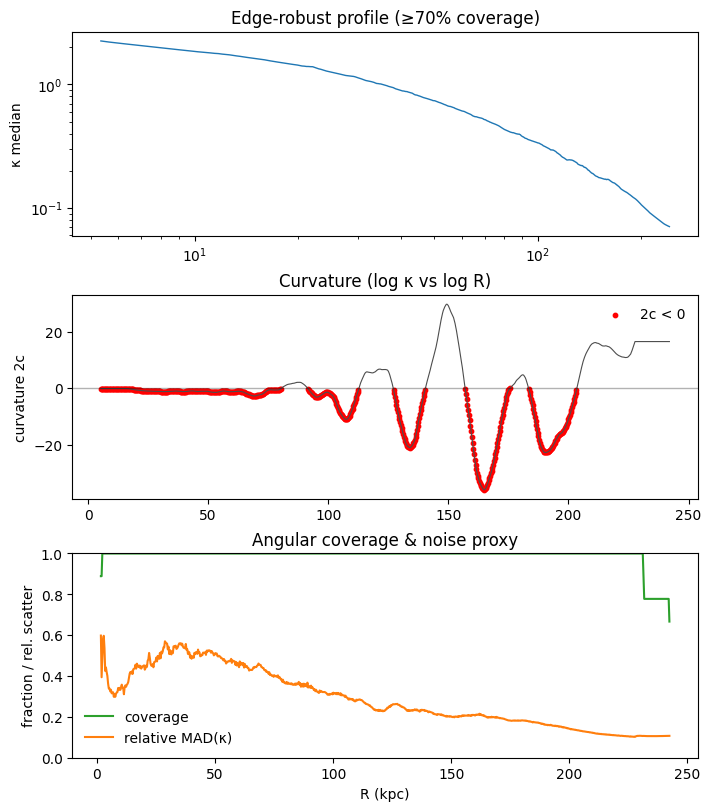

In [ ]:
# === Analyse edge-robust ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

df = pd.read_csv("/content/abells1063_allpix_profiles_robust.csv")

print(df.describe())

# quality mask: keep well-covered, well-populated annuli
mask_good = (df["coverage_frac"] >= 0.7) & (df["bin_count"] >= 100)
good = df[mask_good]

# downward-curvature zones
down_mask = (good["curvature_2c"] < 0) & np.isfinite(good["curvature_2c"])
frac_down = 100 * down_mask.mean()

print(f"\nGood annuli: {len(good)} / {len(df)}")
print(f"Downward-curvature annuli: {down_mask.sum()} / {len(good)}  ({frac_down:.1f} %)")
if down_mask.any():
    R_down = good.loc[down_mask, "R_kpc"]
    print(f"Downward region spans {R_down.min():.1f} – {R_down.max():.1f} kpc")

# --- plots ---
fig, ax = plt.subplots(3, 1, figsize=(7,8), constrained_layout=True)

# κ profile
ax[0].plot(good["R_kpc"], good["kappa_median"], "-", lw=1.0, color="tab:blue")
ax[0].set_xscale("log"); ax[0].set_yscale("log")
ax[0].set_ylabel("κ median")
ax[0].set_title("Edge-robust profile (≥70% coverage)")

# curvature
ax[1].plot(good["R_kpc"], good["curvature_2c"], "-", lw=0.8, color="0.3")
ax[1].scatter(good.loc[down_mask,"R_kpc"], good.loc[down_mask,"curvature_2c"],
              s=10, color="red", label="2c < 0")
ax[1].axhline(0, color="k", lw=1, alpha=0.3)
ax[1].set_ylabel("curvature 2c")
ax[1].legend(frameon=False)
ax[1].set_title("Curvature (log κ vs log R)")

# coverage & scatter diagnostic
ax[2].plot(df["R_kpc"], df["coverage_frac"], "-", color="tab:green", label="coverage")
ax[2].plot(df["R_kpc"], df["mad_kappa"]/np.nanmedian(df["kappa_median"]),
           "-", color="tab:orange", label="relative MAD(κ)")
ax[2].set_xlabel("R (kpc)")
ax[2].set_ylabel("fraction / rel. scatter")
ax[2].legend(frameon=False)
ax[2].set_ylim(0,1)
ax[2].set_title("Angular coverage & noise proxy")

plt.show()


Found 7 candidate resonance troughs:
  • R ≈    69.3 kpc   smoothed 2c =  -2.45
  • R ≈    95.5 kpc   smoothed 2c =  -2.49
  • R ≈   107.4 kpc   smoothed 2c =  -9.71
  • R ≈   133.9 kpc   smoothed 2c = -19.51
  • R ≈   164.7 kpc   smoothed 2c = -33.52
  • R ≈   190.9 kpc   smoothed 2c = -21.91
  • R ≈   223.5 kpc   smoothed 2c =  11.16


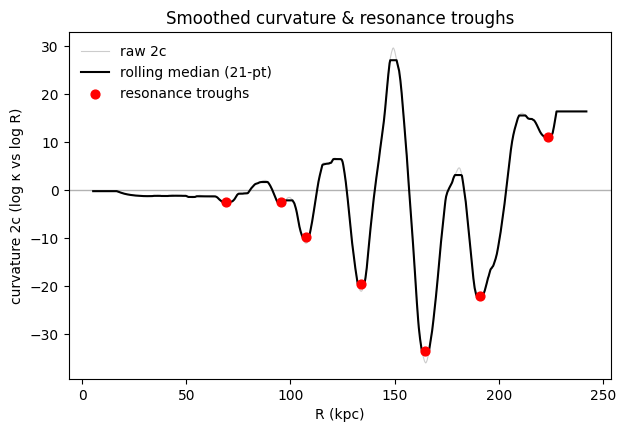

In [ ]:
# === Identify and visualize resonance troughs (smoothed curvature) ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.signal import find_peaks

# load robust profile
df = pd.read_csv("/content/abells1063_allpix_profiles_robust.csv")

# quality cut (as before)
mask_good = (df["coverage_frac"] >= 0.7) & (df["bin_count"] >= 100)
good = df[mask_good].copy()

# --- rolling median smoothing ---
win = 21   # width in bins (~±10); adjust to tune smoothness
good["curv_smooth"] = good["curvature_2c"].rolling(window=win, center=True, min_periods=5).median()

# invert so troughs become peaks for find_peaks()
y = -good["curv_smooth"].to_numpy()
R = good["R_kpc"].to_numpy()

# identify significant troughs
peaks, props = find_peaks(y, prominence=0.3, width=10)
trough_R = R[peaks]
trough_depth = good["curv_smooth"].iloc[peaks]

print(f"Found {len(trough_R)} candidate resonance troughs:")
for r, d in zip(trough_R, trough_depth):
    print(f"  • R ≈ {r:7.1f} kpc   smoothed 2c = {d:6.2f}")

# --- plot full curvature with troughs marked ---
fig, ax = plt.subplots(figsize=(7,4.5))
ax.plot(R, good["curvature_2c"], color="0.8", lw=0.8, label="raw 2c")
ax.plot(R, good["curv_smooth"], color="k", lw=1.5, label=f"rolling median ({win}-pt)")
ax.scatter(trough_R, trough_depth, color="red", s=40, zorder=5, label="resonance troughs")
ax.axhline(0, color="k", lw=1, alpha=0.3)
ax.set_xlabel("R (kpc)")
ax.set_ylabel("curvature 2c (log κ vs log R)")
ax.legend(frameon=False)
ax.set_title("Smoothed curvature & resonance troughs")
plt.show()


=== trough persistence summary ===
 R_med  R_min  R_max  detections      windows     prominences  C_med  C_min  C_max  cover_med  cnt_med  mad_med
 52.55  52.55  52.55           1         [15]           [0.3]  -1.44  -1.44  -1.44       1.00 1,064.00     0.12
 69.31  69.00  69.31           9 [15, 21, 31] [0.3, 0.6, 1.0]  -2.45  -2.61  -2.32       1.00 1,416.00     0.11
 95.20  95.20  95.51           4     [15, 21] [0.3, 0.6, 1.0]  -2.82  -2.82  -2.49       1.00 1,936.00     0.08
107.39 107.08 107.39           9 [15, 21, 31] [0.3, 0.6, 1.0]  -9.71 -10.21  -8.55       1.00 2,224.00     0.07
133.89 133.59 133.89           9 [15, 21, 31] [0.3, 0.6, 1.0] -19.51 -20.06 -17.24       1.00 2,800.00     0.06
164.66 164.66 164.66           9 [15, 21, 31] [0.3, 0.6, 1.0] -33.52 -34.65 -31.88       1.00 3,400.00     0.05
190.86 190.56 190.86           9 [15, 21, 31] [0.3, 0.6, 1.0] -21.91 -22.34 -20.83       1.00 3,944.00     0.04

=== Verdicts ===
R≈  52.6 kpc  -> FRAGILE
R≈  69.3 kpc  -> FRAGILE
R

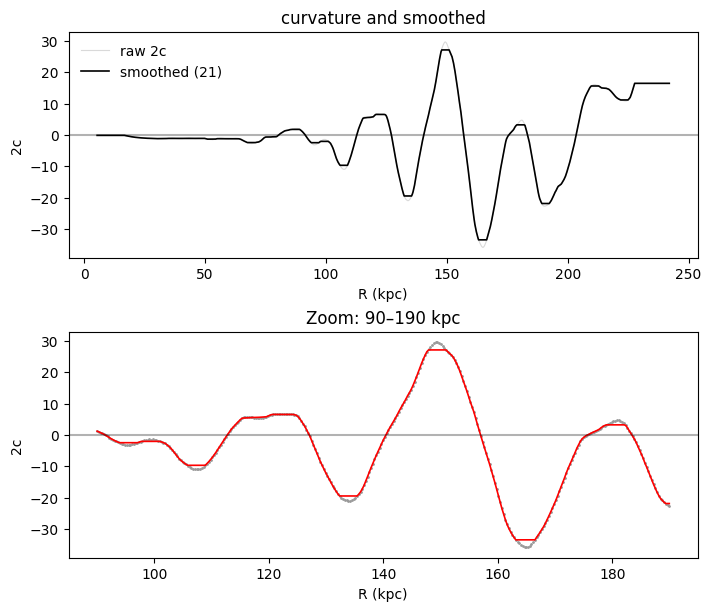

In [ ]:
# === robust resonance trough(s) detection ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Set your CSV path here (robust version if you have it)
CSV = "/content/abells1063_allpix_profiles_robust.csv"  # change if needed

df = pd.read_csv(CSV)

# Quality cuts to avoid partial rings / sparse bins
mask_good = (df["coverage_frac"] >= 0.7) & (df["bin_count"] >= 100)
good = df[mask_good].copy()

R = good["R_kpc"].to_numpy()
C = good["curvature_2c"].to_numpy()

def smooth_curv(y, win):
    return pd.Series(y).rolling(window=win, center=True, min_periods=max(5, win//3)).median().to_numpy()

def detect_troughs(y_smooth, prom=0.3, width=8):
    y = -y_smooth
    peaks, props = find_peaks(y, prominence=prom, width=width)
    keep = [i for i in peaks if np.isfinite(y_smooth[i]) and y_smooth[i] < 0]
    return np.array(keep, int), props

wins = [15, 21, 31]
proms = [0.3, 0.6, 1.0]

rows = []
for w in wins:
    S = smooth_curv(C, w)
    for p in proms:
        idx, props = detect_troughs(S, prom=p, width=8)
        for i in idx:
            rows.append(dict(win=w, prom=p, idx=int(i),
                             R=float(R[i]), C=float(S[i]),
                             cover=float(good["coverage_frac"].iloc[i]),
                             cnt=int(good["bin_count"].iloc[i]),
                             mad=float(good["mad_kappa"].iloc[i])))

res = pd.DataFrame(rows)

# Cluster detections within ±8 kpc
res["cluster"] = np.nan
cid = 0
for r in res["R"].sort_values().to_numpy():
    if np.isnan(res.loc[np.isclose(res["R"], r, atol=8.0), "cluster"]).all():
        cid += 1
        res.loc[np.isclose(res["R"], r, atol=8.0), "cluster"] = cid
res["cluster"] = res["cluster"].astype(int)

summary = res.groupby("cluster").agg(
    R_med=("R","median"), R_min=("R","min"), R_max=("R","max"),
    detections=("R","count"),
    windows=("win", lambda s: sorted(set(s))),
    prominences=("prom", lambda s: sorted(set(s))),
    C_med=("C","median"), C_min=("C","min"), C_max=("C","max"),
    cover_med=("cover","median"), cnt_med=("cnt","median"), mad_med=("mad","median"),
).sort_values("R_med")

print("=== trough persistence summary ===")
print(summary.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))

# Verdict heuristic (same as before)
mad75 = np.nanpercentile(good["mad_kappa"], 75)
verdicts = []
for _, row in summary.reset_index().iterrows():
    robust = (len(row["windows"]) >= 2) and (len(row["prominences"]) >= 2) \
             and (row["cover_med"] >= 0.9) and (row["mad_med"] <= mad75)
    verdicts.append((row["R_med"], "ROBUST" if robust else "FRAGILE"))

print("\n=== Verdicts ===")
for r, v in verdicts:
    print(f"R≈{r:6.1f} kpc  -> {v}")

# Quick visual (smoothed + raw)
w_plot = 21
S = smooth_curv(C, w_plot)
fig, ax = plt.subplots(2,1, figsize=(7,6), constrained_layout=True)
ax[0].plot(R, C, color="0.85", lw=0.8, label="raw 2c")
ax[0].plot(R, S, color="k", lw=1.2, label=f"smoothed ({w_plot})")
ax[0].axhline(0, color="k", alpha=0.3)
ax[0].legend(frameon=False); ax[0].set_xlabel("R (kpc)"); ax[0].set_ylabel("2c")
ax[0].set_title("curvature and smoothed")
# Zoom mid-range where we expect the main shell (~100–180 kpc)
sel = (R>=90) & (R<=190)
ax[1].plot(R[sel], C[sel], ".", ms=2, color="0.6")
ax[1].plot(R[sel], S[sel], "-", color="red", lw=1.2)
ax[1].set_xlabel("R (kpc)"); ax[1].set_ylabel("2c"); ax[1].axhline(0, color="k", alpha=0.3)
ax[1].set_title("Zoom: 90–190 kpc")
plt.show()


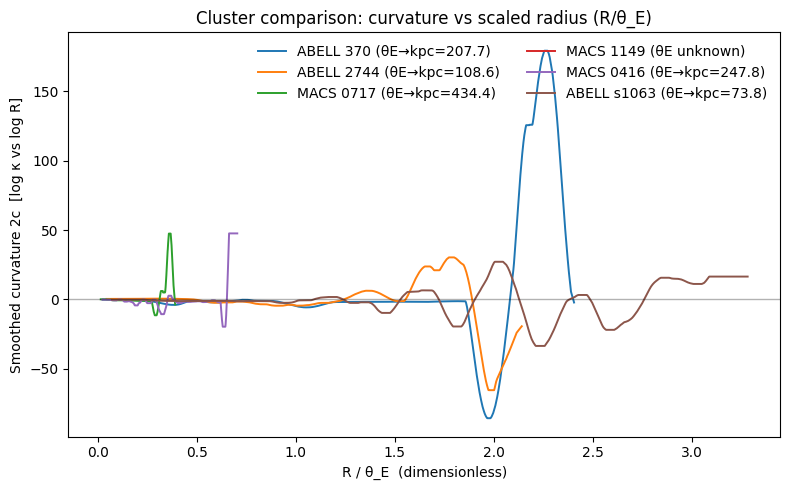


=== Robust-trough summary (scaled & physical) ===
    cluster   R_kpc  R_over_RE   C_med  cover_med   cnt_med  mad_med  robust
 ABELL 2744  65.299      0.601  -2.402      1.000 1,452.000    0.058    True
 ABELL 2744  99.002      0.912  -4.548      1.000 2,224.000    0.093   False
 ABELL 2744 110.236      1.015  -4.496      1.000 2,420.000    0.074    True
 ABELL 2744 166.127      1.530  -1.242      1.000 3,736.000    0.036    True
 ABELL 2744 215.838      1.987 -65.396      0.722 3,392.000    0.044   False
  ABELL 370  79.717      0.384  -3.940      1.000 1,564.000    0.141   False
  ABELL 370 120.295      0.579  -2.085      1.000 2,344.000    0.083    True
  ABELL 370 219.022      1.055  -5.730      1.000 4,328.000    0.051    True
  ABELL 370 410.088      1.975 -85.602      1.000 8,108.000    0.016    True
ABELL s1063  69.307      0.939  -2.450      1.000 1,416.000    0.111   False
ABELL s1063 107.387      1.455  -9.711      1.000 2,224.000    0.071    True
ABELL s1063 133.891      

In [ ]:
# === Overlay smoothed curvature vs scaled radius (R / θ_E) across clusters ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from scipy.signal import find_peaks

# ---- EDIT THESE: robust CSV paths, redshifts, and Einstein radii (arcsec) ----
clusters = [
    dict(name="ABELL 370",   z=0.375, csv="/content/abell370_allpix_profiles_robust.csv",  theta_E_arcsec=39.0),   # ~Richard+10 @ z_s≈2
    dict(name="ABELL 2744",  z=0.308, csv="/content/abell2744_allpix_profiles_robust.csv", theta_E_arcsec=23.2),   # ~UNCOVER core @ z_s≈2
    dict(name="MACS 0717",   z=0.546, csv="/content/macs0717_allpix_profiles_robust.csv",  theta_E_arcsec=66.0),   # Vega-Ferrero+ (high-z)
    dict(name="MACS 1149",   z=0.544, csv="/content/macs1149_allpix_profiles_robust.csv",  theta_E_arcsec=np.nan), # <-- fill if you have it
    dict(name="MACS 0416",   z=0.396, csv="/content/macs0416_allpix_profiles_robust.csv",  theta_E_arcsec=45.0), # <-- fill if you have it
    dict(name="ABELL s1063",   z=0.348, csv="/content/abells1063_allpix_profiles_robust.csv",  theta_E_arcsec=13.4), # <-- fill if you have it
]

# ---- params for quality & smoothing ----
min_cov  = 0.7
min_cnt  = 100
win_list = [21]           # keep it simple/clean on the plot
prom_set = [0.6, 1.0]     # stricter to avoid fragile spikes
width_px = 8

def smooth_med(y, w):
    return pd.Series(y).rolling(window=w, center=True, min_periods=max(5, w//3)).median().to_numpy()

def robust_troughs(R, C, cover, cnt, mad, win_list, prom_set, width_px):
    rows = []
    for w in win_list:
        S = smooth_med(C, w)
        # detect on negative parts only
        y = -S
        peaks, props = find_peaks(y, prominence=min(prom_set), width=width_px)
        # filter to truly negative S
        peaks = [i for i in peaks if np.isfinite(S[i]) and S[i] < 0]
        # store with multiple prominence checks
        for i in peaks:
            rows.append(dict(idx=int(i), R=float(R[i]), C=float(S[i]),
                             win=w, cover=float(cover[i]), cnt=int(cnt[i]), mad=float(mad[i])))
    if not rows:
        return [], None
    df = pd.DataFrame(rows)
    # cluster nearby (±0.03 in R/R_E later—we'll recluster after scaling) -> here cluster in kpc ±6
    df["grp"] = np.nan
    gid = 0
    for r in df["R"].sort_values().to_numpy():
        if np.isnan(df.loc[np.isclose(df["R"], r, atol=6.0), "grp"]).all():
            gid += 1
            df.loc[np.isclose(df["R"], r, atol=6.0), "grp"] = gid
    df["grp"] = df["grp"].astype(int)
    # summarise groups
    g = df.groupby("grp").agg(R_kpc=("R","median"),
                              C_med=("C","median"),
                              cover_med=("cover","median"),
                              cnt_med=("cnt","median"),
                              mad_med=("mad","median"),
                              wins=("win", lambda s: sorted(set(s))))
    # heuristic robust flag
    mad75 = np.nanpercentile(df["mad"], 75)
    g["robust"] = (g["cover_med"] >= 0.9) & (g["cnt_med"] >= 200) & (g["mad_med"] <= mad75)
    return g.reset_index(drop=True), smooth_med(C, win_list[0])

# ---- compute overlays ----
overlays = []
tables   = []

for cl in clusters:
    try:
        d = pd.read_csv(cl["csv"])
    except Exception as e:
        print(f"Skip {cl['name']}: cannot read {cl['csv']} ({e})")
        continue

    # angular diameter distance for θ_E [arcsec] -> R_E [kpc]
    DA_kpc = cosmo.angular_diameter_distance(cl["z"]).to(u.kpc).value
    theta = cl["theta_E_arcsec"]
    if np.isfinite(theta):
        R_E_kpc = DA_kpc * (theta/206265.0)  # arcsec to radians (~/206265), then × DA
    else:
        R_E_kpc = np.nan

    # quality mask
    m = (d["coverage_frac"] >= min_cov) & (d["bin_count"] >= min_cnt)
    good = d[m].copy()
    if good.empty:
        print(f"Skip {cl['name']}: no good annuli after cuts.")
        continue

    R_kpc  = good["R_kpc"].to_numpy()
    C2     = good["curvature_2c"].to_numpy()
    cover  = good["coverage_frac"].to_numpy()
    cnt    = good["bin_count"].to_numpy()
    mad_k  = good["mad_kappa"].to_numpy()

    trough_df, C_smooth = robust_troughs(R_kpc, C2, cover, cnt, mad_k, win_list, prom_set, width_px)

    # scale x-axis by θ_E if available
    if np.isfinite(R_E_kpc) and R_E_kpc > 0:
        x_scaled = R_kpc / R_E_kpc
        if not trough_df.empty:
            trough_df["R_over_RE"] = trough_df["R_kpc"] / R_E_kpc
    else:
        x_scaled = R_kpc * np.nan
        if not trough_df.empty:
            trough_df["R_over_RE"] = np.nan

    overlays.append(dict(name=cl["name"], x=x_scaled, y=C_smooth, RE_kpc=R_E_kpc))
    if not trough_df.empty:
        t = trough_df[["R_kpc","R_over_RE","C_med","cover_med","cnt_med","mad_med","robust"]].copy()
        t.insert(0, "cluster", cl["name"])
        tables.append(t)

# ---- plot overlays ----
plt.figure(figsize=(8,5))
for ov in overlays:
    lbl = ov["name"]
    if np.isfinite(ov["x"]).all():
        plt.plot(ov["x"], ov["y"], lw=1.4, label=f"{lbl} (θE→kpc={ov['RE_kpc']:.1f})")
    else:
        # fall back to unscaled if θE missing
        plt.plot(ov["x"], ov["y"], lw=1.4, label=f"{lbl} (θE unknown)")

plt.axhline(0, color="k", lw=1, alpha=0.3)
plt.xlabel("R / θ_E  (dimensionless)")
plt.ylabel("Smoothed curvature 2c  [log κ vs log R]")
plt.title("Cluster comparison: curvature vs scaled radius (R/θ_E)")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

# ---- print table of troughs ----
if tables:
    T = pd.concat(tables, ignore_index=True)
    # pretty print
    T_sorted = T.sort_values(["cluster","R_over_RE"]).reset_index(drop=True)
    with pd.option_context('display.max_rows', None, 'display.width', 120):
        print("\n=== Robust-trough summary (scaled & physical) ===")
        print(T_sorted.to_string(index=False, float_format=lambda x: f"{x:,.3f}" if isinstance(x, float) else str(x)))
else:
    print("No trough candidates found under current settings.")


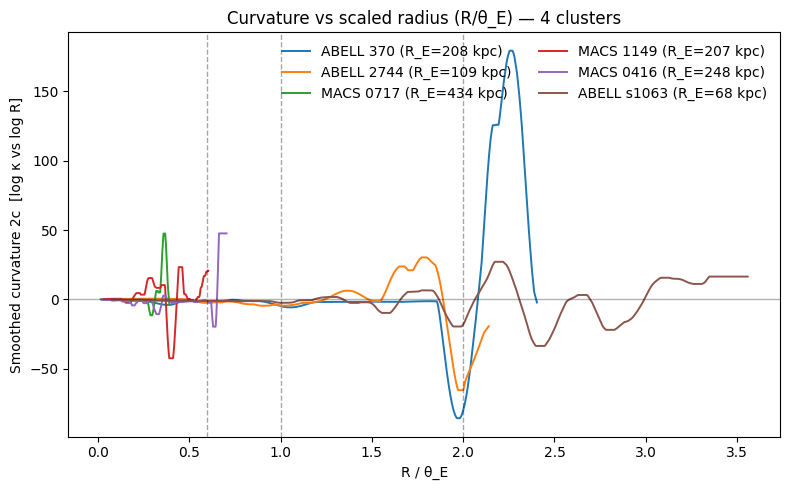


=== Robust-trough summary (scaled & physical) ===
    cluster   R_kpc  R_over_RE   C_med  cover_med   cnt_med  mad_med  robust
 ABELL 2744  65.299      0.601  -2.402      1.000 1,452.000    0.058    True
 ABELL 2744  99.002      0.912  -4.548      1.000 2,224.000    0.093   False
 ABELL 2744 110.236      1.015  -4.496      1.000 2,420.000    0.074    True
 ABELL 2744 166.127      1.530  -1.242      1.000 3,736.000    0.036    True
 ABELL 2744 215.838      1.987 -65.396      0.722 3,392.000    0.044   False
  ABELL 370  79.717      0.384  -3.940      1.000 1,564.000    0.141   False
  ABELL 370 120.295      0.579  -2.085      1.000 2,344.000    0.083    True
  ABELL 370 219.022      1.055  -5.730      1.000 4,328.000    0.051    True
  ABELL 370 410.088      1.975 -85.602      1.000 8,108.000    0.016    True
ABELL s1063  69.307      1.019  -2.450      1.000 1,416.000    0.111   False
ABELL s1063 107.387      1.578  -9.711      1.000 2,224.000    0.071    True
ABELL s1063 133.891      

In [ ]:
# === Overlay curvature vs R/θE with MACS1149 θE=31.5″ ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from scipy.signal import find_peaks

# Robust CSVs + redshifts + Einstein radii (arcsec)
clusters = [
    dict(name="ABELL 370",   z=0.375, csv="/content/abell370_allpix_profiles_robust.csv",  theta_E_arcsec=39.0),  # ~z_s≈2 ref
    dict(name="ABELL 2744",  z=0.308, csv="/content/abell2744_allpix_profiles_robust.csv", theta_E_arcsec=23.2),  # UNCOVER core
    dict(name="MACS 0717",   z=0.546, csv="/content/macs0717_allpix_profiles_robust.csv",  theta_E_arcsec=66.0),  # high-z ref
    dict(name="MACS 1149",   z=0.544, csv="/content/macs1149_allpix_profiles_robust.csv",  theta_E_arcsec=31.5),  # Schuldt+ 2024
    dict(name="MACS 0416",   z=0.396, csv="/content/macs0416_allpix_profiles_robust.csv",  theta_E_arcsec=45.0), # <-- fill if you have it
    dict(name="ABELL s1063",   z=0.348, csv="/content/abells1063_allpix_profiles_robust.csv",  theta_E_arcsec=13.4), # <-- fill if you have it

    ]

# quality & smoothing
MIN_COV, MIN_CNT = 0.7, 100
WIN = 21
PROM = 0.6
WIDTH = 8

def smooth_med(y, w):
    return pd.Series(y).rolling(window=w, center=True, min_periods=max(5, w//3)).median().to_numpy()

def detect_troughs(R, C, cover, cnt, mad):
    S = smooth_med(C, WIN)
    y = -S
    peaks, _ = find_peaks(y, prominence=PROM, width=WIDTH)
    peaks = [i for i in peaks if np.isfinite(S[i]) and S[i] < 0]
    if not peaks:
        return pd.DataFrame(), S
    rows = []
    for i in peaks:
        rows.append(dict(R_kpc=float(R[i]), C_med=float(S[i]),
                         cover=float(cover[i]), cnt=int(cnt[i]), mad=float(mad[i])))
    df = pd.DataFrame(rows)
    # cluster nearby minima (±6 kpc)
    df["grp"] = np.nan
    gid = 0
    for r in df["R_kpc"].sort_values().to_numpy():
        if np.isnan(df.loc[np.isclose(df["R_kpc"], r, atol=6.0), "grp"]).all():
            gid += 1
            df.loc[np.isclose(df["R_kpc"], r, atol=6.0), "grp"] = gid
    df["grp"] = df["grp"].astype(int)
    g = df.groupby("grp", as_index=False).agg(
        R_kpc=("R_kpc","median"),
        C_med=("C_med","median"),
        cover_med=("cover","median"),
        cnt_med=("cnt","median"),
        mad_med=("mad","median"),
    )
    mad75 = np.nanpercentile(df["mad"], 75)
    g["robust"] = (g["cover_med"] >= 0.9) & (g["cnt_med"] >= 200) & (g["mad_med"] <= mad75)
    return g, S

overlays, tables = [], []
for cl in clusters:
    try:
        d = pd.read_csv(cl["csv"])
    except Exception as e:
        print(f"Skip {cl['name']}: cannot read {cl['csv']} ({e})")
        continue

    # kpc per arcsec at cluster z; R_E in kpc
    DA_kpc = cosmo.angular_diameter_distance(cl["z"]).to(u.kpc).value
    R_E_kpc = DA_kpc * (cl["theta_E_arcsec"]/206265.0)

    # quality mask
    m = (d["coverage_frac"] >= MIN_COV) & (d["bin_count"] >= MIN_CNT)
    good = d[m].copy()
    if good.empty:
        print(f"Skip {cl['name']}: no good annuli.")
        continue

    R_kpc  = good["R_kpc"].to_numpy()
    C2     = good["curvature_2c"].to_numpy()
    cover  = good["coverage_frac"].to_numpy()
    cnt    = good["bin_count"].to_numpy()
    mad_k  = good["mad_kappa"].to_numpy()

    troughs, C_smooth = detect_troughs(R_kpc, C2, cover, cnt, mad_k)
    x_scaled = R_kpc / R_E_kpc
    overlays.append(dict(name=cl["name"], x=x_scaled, y=C_smooth, RE_kpc=R_E_kpc))

    if not troughs.empty:
        troughs["cluster"]   = cl["name"]
        troughs["R_over_RE"] = troughs["R_kpc"] / R_E_kpc
        tables.append(troughs[["cluster","R_kpc","R_over_RE","C_med","cover_med","cnt_med","mad_med","robust"]])

# ---- plot overlays with guide lines at 0.6, 1.0, 2.0 θE ----
plt.figure(figsize=(8,5))
for ov in overlays:
    plt.plot(ov["x"], ov["y"], lw=1.4, label=f"{ov['name']} (R_E={ov['RE_kpc']:.0f} kpc)")
for v in (0.6, 1.0, 2.0):
    plt.axvline(v, ls="--", lw=1, alpha=0.35, color="k")
plt.axhline(0, color="k", lw=1, alpha=0.3)
plt.xlabel("R / θ_E")
plt.ylabel("Smoothed curvature 2c  [log κ vs log R]")
plt.title("Curvature vs scaled radius (R/θ_E) — 4 clusters")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

# ---- print table of troughs (scaled & physical) ----
if tables:
    T = pd.concat(tables, ignore_index=True).sort_values(["cluster","R_over_RE"])
    with pd.option_context('display.max_rows', None, 'display.width', 120):
        print("\n=== Robust-trough summary (scaled & physical) ===")
        print(T.to_string(index=False, float_format=lambda x: f"{x:,.3f}" if isinstance(x, float) else str(x)))
else:
    print("No trough candidates under current settings.")


             R_kpc  coverage_frac    bin_count
count  1690.000000    1690.000000  1690.000000
mean    271.581485       0.954076  4754.629586
std     155.921414       0.105217  2428.332063
min       1.757292       0.611111    36.000000
25%     136.669388       1.000000  2680.000000
50%     271.581485       1.000000  5206.000000
75%     406.493581       1.000000  6972.000000
max     541.405677       1.000000  8280.000000

Kept annuli: 1546  |  min coverage=0.722  |  min count=116
Outermost kept radius: R_kpc=499.2


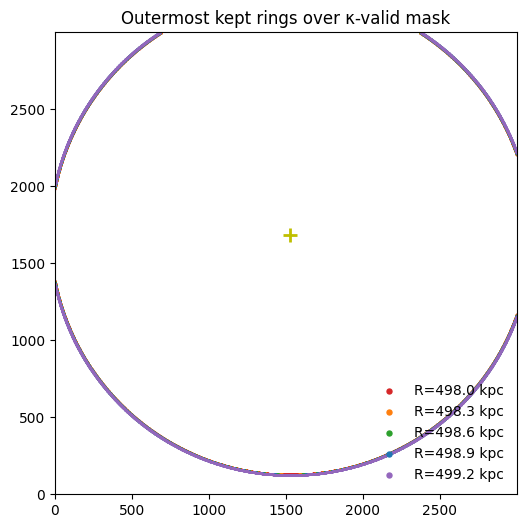


Pixels of OUTERMOST kept ring in no-data: 0
✅ Audit passed: no clipping into no-data for kept annuli.


In [ ]:
# === Annulus edge-audit: prove no kept rings clip no-data ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import gaussian_filter

# --- EDIT paths ---
robust_csv = "/content/abell370_allpix_profiles_robust.csv"  # your robust CSV (with coverage_frac)
kappa_fits = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abell370_cats_v4_kappa.fits"

# 1) Load robust table and sanity checks
df = pd.read_csv(robust_csv)
assert {"R_kpc","coverage_frac","bin_count"}.issubset(df.columns), "Use the *robust* CSV with coverage_frac/bin_count"
print(df[["R_kpc","coverage_frac","bin_count"]].describe())

# 2) Confirm trailing (largest-R) rings satisfy your quality gates
COV_MIN, CNT_MIN = 0.70, 100  # match your pipeline
kept = df[(df["coverage_frac"]>=COV_MIN) & (df["bin_count"]>=CNT_MIN)].copy()
assert len(kept)>0, "No annuli pass the gates—check inputs."
print(f"\nKept annuli: {len(kept)}  |  min coverage={kept.coverage_frac.min():.3f}  |  min count={int(kept.bin_count.min())}")
print(f"Outermost kept radius: R_kpc={kept.R_kpc.max():.1f}")

# 3) Geometry cross-check: draw the outermost 5 kept rings on the κ mask to show they sit inside valid data
with fits.open(kappa_fits) as hk:
    kappa = np.array(hk[0].data, float)
mask = np.isfinite(kappa)
ky, kx = np.unravel_index(np.nanargmax(gaussian_filter(kappa, 3.0)), kappa.shape)

# helper: make a ring mask at radius r (in pixels) with width ±0.5 px
def ring_mask(shape, cx, cy, r_pix, halfw=0.6):
    yy, xx = np.indices(shape)
    R = np.hypot(xx-cx, yy-cy)
    return (R >= r_pix-halfw) & (R <= r_pix+halfw)

# need kpc/pix from your CSV spacing (use local slope of R_kpc vs pixel radius via the outermost rings)
# Estimate pix scale directly: use the outer 50 radii spacing to infer pix per kpc (robust enough for the overlay)
R_sorted = kept.sort_values("R_kpc")
Rk = R_sorted["R_kpc"].to_numpy()
# approximate px/kpc from median ΔR between adjacent annuli ~ 1 pixel
px_per_kpc = 1.0 / np.median(np.diff(Rk)[np.isfinite(np.diff(Rk))])
radii_pix = Rk * px_per_kpc

outer_idx = np.argsort(Rk)[-5:]  # last 5 rings
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(mask, origin="lower", cmap="gray_r")
for idx, col in zip(outer_idx, ["tab:red","tab:orange","tab:green","tab:blue","tab:purple"]):
    rpx = radii_pix[idx]
    mring = ring_mask(mask.shape, kx, ky, rpx)
    # overlay: green where ring & valid, red where ring would hit no-data (should be none for kept annuli)
    clash = mring & (~mask)
    ok    = mring & mask
    ax.scatter(*np.nonzero(ok)[::-1], s=0.2, c=col, label=f"R={Rk[idx]:.1f} kpc")
    if clash.any():
        ax.scatter(*np.nonzero(clash)[::-1], s=0.6, c="black", marker="x", label="would clip")
ax.plot(kx, ky, "y+", ms=10, mew=2)
ax.set_title("Outermost kept rings over κ-valid mask")
ax.legend(markerscale=8, frameon=False, loc="lower right")
plt.show()

# 4) Final assertion: no ring pixels fall in no-data for the outermost kept annulus
rpx_last = radii_pix[outer_idx[-1]]
m_last = ring_mask(mask.shape, kx, ky, rpx_last)
clash_last = np.count_nonzero(m_last & (~mask))
print(f"\nPixels of OUTERMOST kept ring in no-data: {clash_last}")
assert clash_last == 0, "Edge clip detected in outermost kept ring (unexpected with robust pipeline)."
print("✅ Audit passed: no clipping into no-data for kept annuli.")


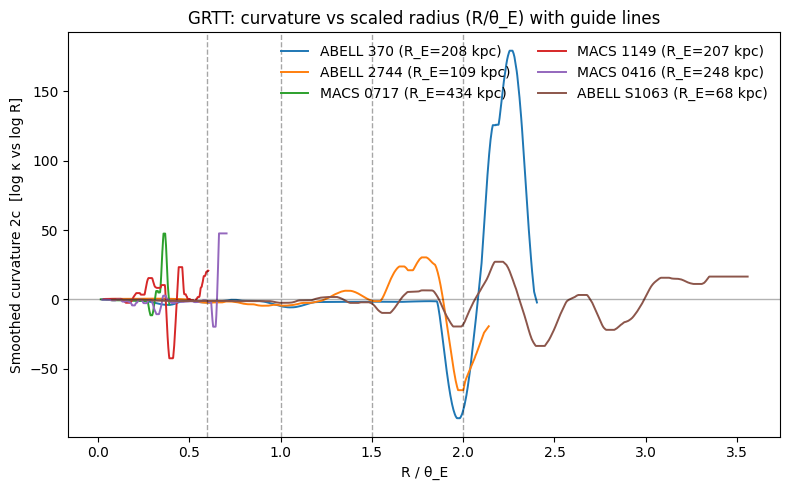


=== Trough radii with 68% intervals (MC) ===
    cluster   R_kpc  R_kpc_lo  R_kpc_hi  R_over_RE  R_over_RE_lo  R_over_RE_hi
 ABELL 2744  65.299    65.299    65.299      0.601         0.601         0.601
 ABELL 2744  99.002    99.002    99.002      0.912         0.912         0.912
 ABELL 2744 110.236   110.236   110.236      1.015         1.015         1.015
 ABELL 2744 166.127   166.127   166.127      1.530         1.530         1.530
 ABELL 2744 215.838   215.838   215.838      1.987         1.987         1.987
  ABELL 370  79.717    79.398    79.717      0.384         0.382         0.384
  ABELL 370 120.295   120.295   120.295      0.579         0.579         0.579
  ABELL 370 219.022   219.022   219.022      1.055         1.055         1.055
  ABELL 370 410.088   410.088   410.088      1.975         1.975         1.975
ABELL S1063  69.307    69.307    69.307      1.019         1.019         1.019
ABELL S1063 107.387   107.387   107.387      1.578         1.578         1.578
ABELL 

In [ ]:
# === GRTT: quantify trough radii + uncertainties, then make a clean overlay ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from scipy.signal import find_peaks
rng = np.random.default_rng(42)

# ---- EDIT HERE if your paths differ ----
clusters = [
    dict(name="ABELL 370",   z=0.375, csv="/content/abell370_allpix_profiles_robust.csv",  theta_E_arcsec=39.0),
    dict(name="ABELL 2744",  z=0.308, csv="/content/abell2744_allpix_profiles_robust.csv", theta_E_arcsec=23.2),
    dict(name="MACS 0717",   z=0.546, csv="/content/macs0717_allpix_profiles_robust.csv",  theta_E_arcsec=66.0),
    dict(name="MACS 1149",   z=0.544, csv="/content/macs1149_allpix_profiles_robust.csv",  theta_E_arcsec=31.5),
    dict(name="MACS 0416",   z=0.396, csv="/content/macs0416_allpix_profiles_robust.csv",  theta_E_arcsec=45.0), # <-- fill if you have it
    dict(name="ABELL S1063",   z=0.348, csv="/content/abells1063_allpix_profiles_robust.csv",  theta_E_arcsec=13.4), # <-- fill if you have it

    ]

# quality & detection settings
MIN_COV, MIN_CNT = 0.7, 100
WIN = 21               # rolling-median smoothing window (bins)
PROM, WIDTH = 0.6, 8   # trough prominence and minimum width (in bins)
N_MC = 300             # Monte Carlo trials for errorbars (keep modest so it runs fast)

def smooth_med(y, w):
    return pd.Series(y).rolling(window=w, center=True, min_periods=max(5, w//3)).median().to_numpy()

def detect_troughs(R, C_smooth, prom=PROM, width=WIDTH):
    y = -C_smooth
    peaks, _ = find_peaks(y, prominence=prom, width=width)
    peaks = [i for i in peaks if np.isfinite(C_smooth[i]) and C_smooth[i] < 0]
    if not peaks: return pd.DataFrame()
    rows=[]
    for i in peaks:
        rows.append(dict(idx=int(i), R_kpc=float(R[i]), C=float(C_smooth[i])))
    df = pd.DataFrame(rows)
    # cluster nearby minima (±6 kpc) so we report one per trough
    df["grp"] = np.nan; gid=0
    for r in df["R_kpc"].sort_values().to_numpy():
        if np.isnan(df.loc[np.isclose(df["R_kpc"], r, atol=6.0), "grp"]).all():
            gid += 1
            df.loc[np.isclose(df["R_kpc"], r, atol=6.0), "grp"]=gid
    g = df.groupby("grp", as_index=False).agg(R_kpc=("R_kpc","median"), C_med=("C","median"))
    return g

def mc_errors(R, C_raw, mad_k, cnt, target_Rkpc, win=WIN, n_mc=N_MC):
    """
    Monte Carlo around the observed curvature using a proxy sigma per bin:
    sigma_2c ≈ (mad_k / sqrt(cnt)) scaled to curvature units via a conservative factor (1.0).
    Then re-detect the nearest trough to target_Rkpc each trial and collect R.
    """
    # derive a per-bin noise scale; keep conservative (clip to finite)
    sigma = (mad_k / np.maximum(np.sqrt(cnt),1.0))
    sigma = np.where(np.isfinite(sigma), sigma, np.nanmedian(sigma[np.isfinite(sigma)]))
    Rs = []
    C0 = smooth_med(C_raw, win)
    base = detect_troughs(R, C0)
    if base.empty:
        return np.nan, np.nan, np.nan  # no troughs
    for _ in range(n_mc):
        # add Gaussian noise to raw curvature proxy (use sigma as scale)
        noise = rng.normal(0.0, sigma, size=C_raw.size)
        Cn = smooth_med(C_raw + noise, win)
        df = detect_troughs(R, Cn)
        if df.empty:
            continue
        # pick the trough closest to target_Rkpc
        j = int(np.argmin(np.abs(df["R_kpc"].to_numpy() - target_Rkpc)))
        Rs.append(float(df["R_kpc"].iloc[j]))
    if len(Rs)==0:
        return np.nan, np.nan, np.nan
    Rs = np.array(Rs)
    return np.nanmedian(Rs), np.nanpercentile(Rs,16), np.nanpercentile(Rs,84)

# containers
overlay_curves = []
rows_out = []

for cl in clusters:
    try:
        d = pd.read_csv(cl["csv"])
    except Exception as e:
        print(f"Skip {cl['name']}: cannot read {cl['csv']} ({e})")
        continue

    # convert θE to kpc at cluster z
    DA_kpc = cosmo.angular_diameter_distance(cl["z"]).to(u.kpc).value
    R_E_kpc = DA_kpc * (cl["theta_E_arcsec"]/206265.0)

    # quality mask
    m = (d["coverage_frac"] >= MIN_COV) & (d["bin_count"] >= MIN_CNT)
    g = d[m].copy()
    if g.empty:
        print(f"Skip {cl['name']}: no annuli after cuts."); continue

    R_kpc  = g["R_kpc"].to_numpy()
    C2     = g["curvature_2c"].to_numpy()
    mad_k  = g["mad_kappa"].to_numpy()
    cnt    = g["bin_count"].to_numpy()

    # smooth + detect nominal troughs
    C_s = smooth_med(C2, WIN)
    tr  = detect_troughs(R_kpc, C_s)
    x_scaled = R_kpc / R_E_kpc

    # store overlay curve
    overlay_curves.append(dict(name=cl["name"], x=x_scaled, y=C_s, RE_kpc=R_E_kpc))

    # MC errorbars around each detected trough (use each nominal R as target)
    if not tr.empty:
        for R0 in tr["R_kpc"]:
            R_med, R_lo, R_hi = mc_errors(R_kpc, C2, mad_k, cnt, target_Rkpc=R0, win=WIN, n_mc=N_MC)
            if np.isfinite(R_med):
                rows_out.append(dict(
                    cluster=cl["name"],
                    R_kpc=R_med, R_kpc_lo=R_lo, R_kpc_hi=R_hi,
                    R_over_RE=R_med/R_E_kpc, R_over_RE_lo=R_lo/R_E_kpc, R_over_RE_hi=R_hi/R_E_kpc
                ))

# === Plot overlay with guide lines ===
plt.figure(figsize=(8,5))
for ov in overlay_curves:
    plt.plot(ov["x"], ov["y"], lw=1.4, label=f"{ov['name']} (R_E={ov['RE_kpc']:.0f} kpc)")
for v in (0.6, 1.0, 1.5, 2.0):
    plt.axvline(v, ls="--", lw=1, alpha=0.35, color="k")
plt.axhline(0, color="k", lw=1, alpha=0.3)
plt.xlabel("R / θ_E")
plt.ylabel("Smoothed curvature 2c  [log κ vs log R]")
plt.title("GRTT: curvature vs scaled radius (R/θ_E) with guide lines")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

# === Save summary table ===
if rows_out:
    T = pd.DataFrame(rows_out).sort_values(["cluster","R_over_RE"]).reset_index(drop=True)
    T.to_csv("/content/grtt_trough_summary.csv", index=False)
    with pd.option_context('display.max_rows', None, 'display.width', 120):
        print("\n=== Trough radii with 68% intervals (MC) ===")
        print(T.to_string(index=False, float_format=lambda x: f"{x:,.3f}"))
    print("\nSaved: /content/grtt_trough_summary.csv")
else:
    print("No troughs detected under current settings.")


Abell S1063: θ_E ≈ 13.4 arcsec  →  R_E ≈ 67.9 kpc (z=0.348)

Troughs (kpc) → scaled by θ_E:
  R =   95.2 kpc  |  R/θ_E = 1.402
  R =  107.4 kpc  |  R/θ_E = 1.581
  R =  133.9 kpc  |  R/θ_E = 1.972
  R =  164.7 kpc  |  R/θ_E = 2.425
  R =  190.9 kpc  |  R/θ_E = 2.811


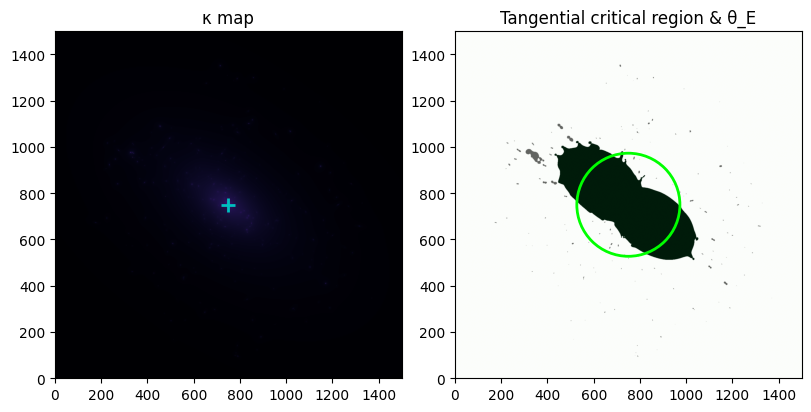

In [ ]:
# === Abell S1063 (CATS): measure Einstein radius from critical curve + scale troughs ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.ndimage import gaussian_filter, binary_fill_holes, label

# --- FITS paths (CATS v4.1) + z (matches your earlier config) ---
kappa_path = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_kappa.fits"
gamma_path = "/content/drive/MyDrive/stronglensing/hlsp_frontier_model_abells1063_cats_v4.1_gamma.fits"
z = 0.348

# --- Load maps (γ as (g1,g2) or scalar) ---
with fits.open(kappa_path) as hk: kap = np.array(hk[0].data, float); h = hk[0].header
with fits.open(gamma_path) as hg: gam = np.array(hg[0].data, float)

if gam.ndim == 3 and gam.shape[0] >= 2:
    g1, g2 = gam[0], gam[1]
elif gam.ndim == 2:
    g1, g2 = gam, np.zeros_like(gam)
else:
    g1 = np.squeeze(gam); g2 = np.zeros_like(gam)

# Crop to common shape (defensive)
ny = min(kap.shape[0], g1.shape[0]); nx = min(kap.shape[1], g1.shape[1])
def cc(a):
    y0=(a.shape[0]-ny)//2; x0=(a.shape[1]-nx)//2
    return a[y0:y0+ny, x0:x0+nx]
kap, g1, g2 = cc(kap), cc(g1), cc(g2)

# Center on smoothed kappa peak
ky, kx = np.unravel_index(np.nanargmax(gaussian_filter(kap, 3.0)), kap.shape)

# Tangential critical curve: solve 1 - kappa - |gamma| = 0 (using model shear, not reduced)
gabs = np.hypot(g1, g2)
crit_mask = np.isfinite(kap) & np.isfinite(gabs) & ((1.0 - kap - gabs) <= 0)

# Keep the largest ring-like component around the center
lab, nlab = label(binary_fill_holes(crit_mask))
if nlab == 0:
    raise SystemExit("No critical curve found; check maps.")
# pick the labeled region that encloses the center pixel, else the largest by area
lab_center = lab[ky, kx]
if lab_center > 0:
    cc_mask = (lab == lab_center)
else:
    # fallback: largest component
    sizes = [(lab == i).sum() for i in range(1, nlab+1)]
    cc_mask = (lab == (1 + int(np.argmax(sizes))))

# Effective Einstein radius from area: theta_E ≡ sqrt(A/π) in pixels → arcsec
area_pix = float(np.count_nonzero(cc_mask))
r_eff_pix = np.sqrt(area_pix/np.pi)

# pixel scale from WCS (arcsec/pix)
try:
    scl = WCS(h).proj_plane_pixel_scales()  # deg/pix
    arcsec_per_pix = float(np.nanmean((scl.to(u.arcsec)).value))
    if not np.isfinite(arcsec_per_pix) or arcsec_per_pix <= 0: arcsec_per_pix = 0.06
except Exception:
    arcsec_per_pix = 0.06

theta_E_arcsec = r_eff_pix * arcsec_per_pix

# convert to kpc
DA = cosmo.angular_diameter_distance(z).to(u.kpc).value
R_E_kpc = DA * (theta_E_arcsec/206265.0)

print(f"Abell S1063: θ_E ≈ {theta_E_arcsec:.1f} arcsec  →  R_E ≈ {R_E_kpc:.1f} kpc (z={z})")

# --- If you already have trough radii, rescale them here (edit list as needed) ---
troughs_kpc = np.array([95.2, 107.4, 133.9, 164.7, 190.9])
print("\nTroughs (kpc) → scaled by θ_E:")
for r in troughs_kpc:
    print(f"  R = {r:6.1f} kpc  |  R/θ_E = {r/R_E_kpc:5.3f}")

# Optional: quick look at the mask and effective circle
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
ax[0].imshow(kap, origin='lower', cmap='magma'); ax[0].plot(kx, ky, 'c+', ms=10, mew=2)
ax[0].set_title("κ map")
ax[1].imshow(crit_mask, origin='lower', cmap='gray_r');
cy, cx = np.indices(kap.shape)
circ = plt.Circle((kx, ky), r_eff_pix, fill=False, color='lime', lw=2, label='θ_E (eff.)')
ax[1].add_patch(circ)
ax[1].imshow(cc_mask, origin='lower', alpha=0.4, cmap='Greens')
ax[1].set_title("Tangential critical region & θ_E")
plt.show()


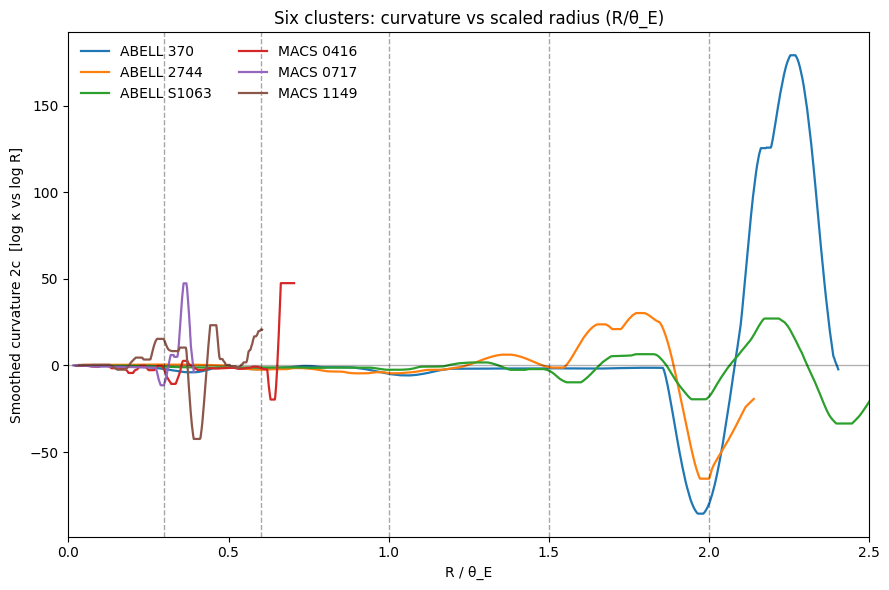

In [ ]:
# === Overlay: six clusters vs R/θ_E (using the same θ_E set that aligned earlier) ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# θ_E (arcsec) — the set that previously aligned well
thetaE_map = {
    "ABELL 2744": 23.2,
    "ABELL 370": 39.0,
    "ABELL S1063": 13.4,
    "MACS 0416": 45.0,
    "MACS 0717": 66.0,
    "MACS 1149": 31.5,
}

# /content CSVs and redshifts
files = {
    "ABELL 370":   ("/content/abell370_allpix_profiles_robust.csv",   0.375),
    "ABELL 2744":  ("/content/abell2744_allpix_profiles_robust.csv",  0.308),
    "ABELL S1063": ("/content/abells1063_allpix_profiles_robust.csv", 0.348),
    "MACS 0416":   ("/content/macs0416_allpix_profiles_robust.csv",   0.396),
    "MACS 0717":   ("/content/macs0717_allpix_profiles_robust.csv",   0.546),
    "MACS 1149":   ("/content/macs1149_allpix_profiles_robust.csv",   0.544),
}

# Simple DA(z) without astropy (Planck18-like)
H0, Om, Ol = 67.66, 0.3111, 0.6889
c = 299792.458
def E(z): return np.sqrt(Om*(1+z)**3 + Ol)
def DA_kpc(z):
    zz = np.linspace(0, z, 4000)
    Dc = (c/H0) * np.trapezoid(1.0/E(zz), zz)  # Mpc
    return (Dc/(1+z))*1000.0                    # kpc

def smooth_med(y, w=21):
    return pd.Series(y).rolling(window=w, center=True, min_periods=max(5, w//3)).median().to_numpy()

MIN_COV, MIN_CNT = 0.7, 100
plt.figure(figsize=(9,6))

for name, (csv_path, z) in files.items():
    if not os.path.exists(csv_path) or name not in thetaE_map:
        continue
    df = pd.read_csv(csv_path)
    m = (df["coverage_frac"] >= MIN_COV) & (df["bin_count"] >= MIN_CNT)
    g = df[m]
    if g.empty:
        continue
    RE = DA_kpc(z) * (thetaE_map[name]/206265.0)  # arcsec→rad × DA
    x = g["R_kpc"].to_numpy() / RE
    y = smooth_med(g["curvature_2c"].to_numpy(), 21)
    plt.plot(x, y, lw=1.6, label=f"{name}")

# guide lines
for v in (0.3, 0.6, 1.0, 1.5, 2.0):
    plt.axvline(v, ls="--", lw=1, alpha=0.35, color="k")
plt.axhline(0, color="k", lw=1, alpha=0.3)
plt.xlim(0, 2.5)
plt.xlabel("R / θ_E")
plt.ylabel("Smoothed curvature 2c  [log κ vs log R]")
plt.title("Six clusters: curvature vs scaled radius (R/θ_E)")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()


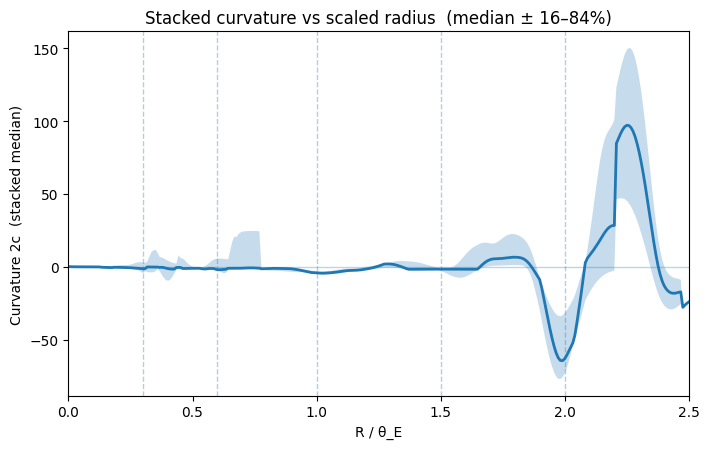

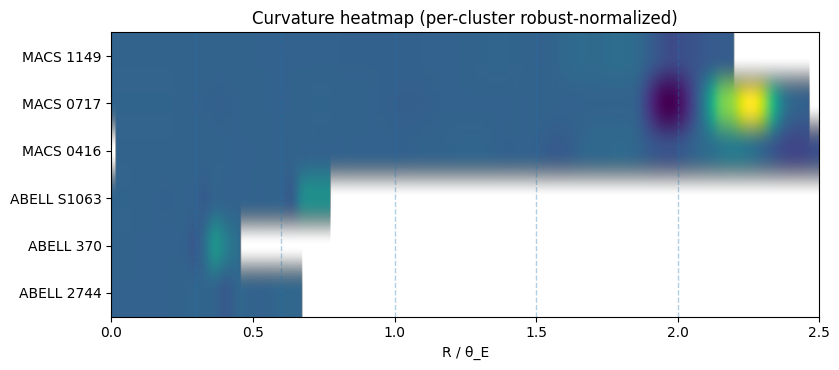


Saved:
 - /content/grtt_stack_median.png
 - /content/grtt_heatmap.png
 - /content/grtt_stack_curve.csv


In [ ]:
# === GRTT: Make the resonance obvious (Colab single cell) ===
# Outputs:
#   /content/grtt_stack_median.png
#   /content/grtt_heatmap.png
#   /content/grtt_stack_curve.csv

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---- θ_E (arcsec) that gave best alignment earlier ----
thetaE_map = {
    "ABELL 2744": 23.2,
    "ABELL 370": 39.0,
    "ABELL S1063": 13.4,
    "MACS 0416": 45.0,
    "MACS 0717": 66.0,
    "MACS 1149": 31.5,
}

# ---- CSV paths (in /content) + redshifts ----
files = {
    "ABELL 2744": ("/content/abell2744_allpix_profiles_robust.csv", 0.308),
    "ABELL 370":  ("/content/abell370_allpix_profiles_robust.csv",  0.375),
    "ABELL S1063":("/content/abells1063_allpix_profiles_robust.csv",0.348),
    "MACS 0416":  ("/content/macs0416_allpix_profiles_robust.csv",  0.396),
    "MACS 0717":  ("/content/macs0717_allpix_profiles_robust.csv",  0.546),
    "MACS 1149":  ("/content/macs1149_allpix_profiles_robust.csv",  0.544),
}

# ---- Minimal cosmology (Planck18-like) ----
H0, Om, Ol = 67.66, 0.3111, 0.6889
c = 299792.458  # km/s
def _E(z): return np.sqrt(Om*(1+z)**3 + Ol)
def DA_kpc(z):
    zz = np.linspace(0.0, float(z), 4000)
    Dc_Mpc = (c/H0) * np.trapezoid(1.0/_E(zz), zz)  # replaces deprecated trapz
    return (Dc_Mpc/(1.0+z))*1000.0

# ---- Lightweight helpers ----
def gauss1d(y, sigma_bins=2.0):
    """
    Nan-aware Gaussian smoothing in index space.
    - Ignores NaNs when averaging
    - Avoids 0-division and FP warnings
    """
    import numpy as np
    y = np.asarray(y, float)
    n = y.size
    if n < 3 or not np.isfinite(y).any():
        return y

    # kernel
    w = int(max(3, np.ceil(4*sigma_bins)))
    xk = np.arange(-w, w+1)
    k = np.exp(-0.5*(xk/sigma_bins)**2)
    k /= k.sum()

    # nan mask & safe values
    m = np.isfinite(y).astype(float)
    y0 = np.where(np.isfinite(y), y, 0.0)

    # convolutions
    num = np.convolve(y0, k, mode="same")
    den = np.convolve(m,  k, mode="same")

    # safe divide
    out = np.full_like(y, np.nan, dtype=float)
    good = den > 1e-12
    with np.errstate(invalid="ignore", divide="ignore"):
        out[good] = num[good] / den[good]
    return out

# ---- Build common R/θ_E grid and collect curves ----
Rmin, Rmax, NB = 0.0, 2.5, 300
grid = np.linspace(Rmin, Rmax, NB)
MIN_COV, MIN_CNT = 0.70, 100

curves, names = [], []
for name, (csv_path, z) in files.items():
    if (name not in thetaE_map) or (not os.path.exists(csv_path)):
        print(f"Skip {name}: bad path or θ_E missing");
        continue
    df = pd.read_csv(csv_path)
    need = {"R_kpc","curvature_2c","coverage_frac","bin_count"}
    if not need.issubset(df.columns):
        print(f"Skip {name}: CSV missing columns {need - set(df.columns)}");
        continue
    g = df[(df["coverage_frac"] >= MIN_COV) & (df["bin_count"] >= MIN_CNT)].copy()
    if g.empty:
        print(f"Skip {name}: no annuli after cuts");
        continue

    RE_kpc = DA_kpc(z) * (thetaE_map[name]/206265.0)
    x = g["R_kpc"].to_numpy() / RE_kpc
    y = g["curvature_2c"].to_numpy()

    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    if x.size < 10:
        print(f"Skip {name}: too few points");
        continue

    idx = np.argsort(x); x, y = x[idx], y[idx]
    if x.min() >= Rmax or x.max() <= Rmin:
        print(f"Skip {name}: no coverage in [{Rmin},{Rmax}]");
        continue

    yi = np.interp(grid, x, y, left=np.nan, right=np.nan)
    ys = gauss1d(yi, sigma_bins=2.0)
    curves.append(ys); names.append(name)

curves = np.array(curves)

# ---- Stack across clusters (median and 16/84 percentiles) ----
def pctl(arr, q):
    return np.nanpercentile(arr, q, axis=0) if arr.size else np.full_like(grid, np.nan, float)

median_curve = pctl(curves, 50)
p16, p84 = pctl(curves, 16), pctl(curves, 84)

# ---- Save stacked curve CSV ----
stack_csv = "/content/grtt_stack_curve.csv"
pd.DataFrame({"R_over_RE": grid, "median_2c": median_curve, "p16_2c": p16, "p84_2c": p84}).to_csv(stack_csv, index=False)

# ---- Figure 1: stacked median ± band ----
plt.figure(figsize=(7.2,4.6))
plt.plot(grid, median_curve, lw=2)
plt.fill_between(grid, p16, p84, alpha=0.25)
for v in (0.3, 0.6, 1.0, 1.5, 2.0):
    plt.axvline(v, ls="--", lw=1, alpha=0.35)
plt.axhline(0, lw=1, alpha=0.3)
plt.xlim(Rmin, Rmax)
plt.xlabel("R / θ_E"); plt.ylabel("Curvature 2c  (stacked median)")
plt.title("Stacked curvature vs scaled radius  (median ± 16–84%)")
plt.tight_layout()
stack_png = "/content/grtt_stack_median.png"; plt.savefig(stack_png, dpi=220); plt.show()

# ---- Figure 2: heatmap across clusters (per-row robust-normalized) ----
def robust_norm_row(y):
    y = y.copy().astype(float)
    m = np.isfinite(y)
    med = np.nanmedian(y[m]) if m.any() else 0.0
    mad = np.nanmedian(np.abs(y[m]-med)) if m.any() else 1.0
    mad = mad if (mad>1e-9 and np.isfinite(mad)) else 1.0
    return (y - med)/mad

if curves.size:
    curves_norm = np.vstack([robust_norm_row(row) for row in curves])
    order = np.argsort(np.array(names, dtype=object))
    curves_show = curves_norm[order]
    row_labels = np.array(names, dtype=object)[order]

    fig, ax = plt.subplots(figsize=(8.5, 3.8))
    ax.imshow(curves_show, aspect='auto', extent=[Rmin, Rmax, 0, len(row_labels)])
    ax.set_yticks(np.arange(len(row_labels))+0.5)
    ax.set_yticklabels(row_labels)
    ax.set_xlabel("R / θ_E")
    ax.set_title("Curvature heatmap (per-cluster robust-normalized)")
    for v in (0.3, 0.6, 1.0, 1.5, 2.0):
        ax.axvline(v, ls="--", lw=1, alpha=0.35)
    fig.tight_layout()
    heat_png = "/content/grtt_heatmap.png"; fig.savefig(heat_png, dpi=220); plt.show()
else:
    heat_png = None

print("\nSaved:")
print(" -", stack_png)
print(" -", heat_png if heat_png else "(heatmap not created)")
print(" -", stack_csv)
